<a href="https://colab.research.google.com/github/Khomiakov7706/requirements_analysis/blob/develop/Requirement_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title libraries import

#import os
#import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

#ML libraries
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import metrics

plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_columns', 500)

#Чтение и обработка начального текста

In [2]:
#@title Data URL. { display-mode: "form" }
data_url = 'https://raw.githubusercontent.com/Khomiakov7706/requirements_analysis/main/train_test_withcols1.csv' #@param {type: 'string'}

In [3]:
data = pd.read_csv(data_url)

In [4]:
data = data.drop('req_type', 1)
data = data.drop('test_scenario', 1)

#@title remove frase 'Verification of ' from requirements classes titles
# Iterate over the columns in the DataFrame
for column in data.columns:
    # Replace the phrase "Verification of " with an empty string
    new_column_name = column.replace("Verification of ", "")
    
    # Rename the column in the DataFrame
    data.rename(columns={column: new_column_name}, inplace=True)

data.rename(columns={'requirement': 'requirement_text',
                     'the Authentication and Authorization process': 'Authentication and Authorization',
                     'the Payment flow and details': 'Payment flow and details',
                     'the Product Page and Products': 'Product Page and Products',
                     'Security and Privacy Policy Set Up': 'Security and Privacy Policy',
                     'Integration, Maintenance of the System and Web Standards': 'Integration'
                     }, inplace=True)

<ipython-input-4-2f76c7524c26>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('req_type', 1)
<ipython-input-4-2f76c7524c26>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('test_scenario', 1)


In [5]:
requirement_classes = list(data.columns[2:].values)

In [6]:
data['classes_count'] = data.iloc[:, 2:].astype(bool).sum(axis=1)

# Лемматизация

In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
def lemmatization(text):
    '''a function for lemmatization'''
    text = [lemmatizer.lemmatize(word.lower()) for word in text.split()]
    # joining the list of words with space separator
    return " ".join(text)

In [9]:
data['lemmatized_requirement'] = data['requirement_text'].apply(lemmatization)

Убираем стоп-слова

In [10]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words 
    text = [word for word in text.split() if word not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [12]:
data['lemmatized_requirement'] = data['lemmatized_requirement'].apply(stopwords)

In [13]:
import re
regex = re.compile('[^a-zA-Z а-яА-Я]')

In [14]:
data.lemmatized_requirement = data.lemmatized_requirement.apply(lambda x: regex.sub('',x))

# Выявление признаков из датасета

## Синтетические признаки

составляем набор признаков на основе текста Dataframe

Количество слов в тексте требования 

In [15]:
data['words_in_requirement'] = (
    data['requirement_text'].str.split().apply(len))

Кол-во слов в тексте лемматизированного требования

In [16]:
data['words_in_lemmatized_req'] = (
    data['lemmatized_requirement'].str.split().apply(len))

Кол-во исключенных слов при лемматизации

In [17]:
data['words_diffence'] = (
    data['words_in_requirement']-data['words_in_lemmatized_req'])

In [18]:
additional_parameters = data.columns[-3:]

## Формирование Bag of Words

Составляем словарь слов для разных классов с указанием количества используемых слов

In [19]:
class_dict = dict()
for c in range(len(requirement_classes)):
    class_dict[requirement_classes[c]] = data[data[requirement_classes[c]]==1]['lemmatized_requirement'].str.split(expand=True).unstack().value_counts().head(25)

Составляем мешок уникальных слов для каждого класса

In [20]:
bag_of_word = []
for i in requirement_classes:
    for j in class_dict[i].index:
        if not (j in bag_of_word):
            bag_of_word.append(j)

In [21]:
type(data)

pandas.core.frame.DataFrame

Выписываем наиболее используемые слова как признаки

In [22]:
bow_data = data.copy()
for word in bag_of_word:
    bow_data[word]=bow_data['lemmatized_requirement'].apply(lambda x: x.count(str (' ' + word + ' ')))

<ipython-input-22-79a2ce9f4cc8>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bow_data[word]=bow_data['lemmatized_requirement'].apply(lambda x: x.count(str (' ' + word + ' ')))
<ipython-input-22-79a2ce9f4cc8>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bow_data[word]=bow_data['lemmatized_requirement'].apply(lambda x: x.count(str (' ' + word + ' ')))
<ipython-input-22-79a2ce9f4cc8>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

In [23]:
bow_data.head(1)

,req_no,requirement_text,Account Details and Settings,Authentication and Authorization,Contact Details,Customer Support,Data Integrity and Consistency,Design and Content,Downloads,Error Handling,Features and Functions,Forms and Validation of Input,Home Page,Language Compatibility,Links,Navigation,Notifications and Alerts,Password Policy and Setup,Payment flow and details,Performance,Product Page and Products,Search and Search Engine Optimization(SEO),Security and Privacy Policy,Social Media Links and Icons,Supportability and Device Compatibility,Usability and Accessibility,all Web Pages in the website,Integration,classes_count,lemmatized_requirement,words_in_requirement,words_in_lemmatized_req,words_diffence,user,contact,account,information,field,shall,number,email,profile,website,include,phone,address,id,password,form,u,page,throw,numbers,link,characters,view,create,change,system,application,able,login,authorized,access,must,register,use,data,log,administrator,support,allow,verify,cm,site,person,provide,detail,resume,company,way,customer,easily,channel,every,including,help,chatbot,service,customers,video,add,etc,make,answer,product,always,reduce,requirement,database,ensure,stored,display,document,file,table,encrypted,transaction,column,eg,update,integrity,organisation,content,image,download,different,downloadable,downloads,language,search,applicant,warranty,error,message,r,failure,priority,name,one,button,server,without,text,reported,go,item,click,tutorial,validation,enter,homepage,progress,home,instructor,bar,tab,depicts,overview,default,logo,web,available,option,url,links,navigation,navigate,main,menu,easy,component,area,category,notify,gpm,notification,buyer,sale,enable,auction,owner,security,future,notified,credit,method,creating,bidder,reset,session,never,users,payment,card,gateway,processor,may,within,time,performance,load,second,seconds,simultaneous,find,similar,show,listing,clear,price,result,searching,title,results,tag,privacy,policy,secure,social,medium,share,icon,browser,firefox,run,internet,work,need,per,class,interface,pages,shallwill,box,explains,software,management,new,standard
0,1,System shall allow users to update their billing and contact information via the “My Account” section of the website,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,system shall allow user update billing contact information via my account section website,19,13,6,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Создаем разметку данных

In [24]:
target = requirement_classes
features = bag_of_word
for i in additional_parameters:
    features.append(i)

# Разбиение на тестовую и валидационную выборки для каждого класса требований для Bag of words

Всего 26 классов

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
def split_train_test (dataframe_, target_, features_):
        
        X_train, X_test, y_train, y_test = train_test_split(dataframe_[features_],dataframe_[target_],test_size=0.2, random_state=77, stratify=dataframe_[target_])
        
        return X_train, X_test, y_train, y_test

In [27]:
for cl in requirement_classes:
  print(cl, '\n', class_dict[cl].value_counts(),'\n\n')

Account Details and Settings 
 6     8
4     7
5     3
7     2
27    1
23    1
17    1
12    1
11    1
dtype: int64 


Authentication and Authorization 
 12     5
13     4
32     2
28     2
15     2
14     2
130    1
40     1
36     1
33     1
31     1
27     1
26     1
17     1
dtype: int64 


Contact Details 
 5     5
11    4
6     4
10    2
9     2
7     2
57    1
26    1
23    1
22    1
17    1
13    1
dtype: int64 


Customer Support 
 5     9
7     4
6     4
8     2
26    1
23    1
22    1
12    1
11    1
9     1
dtype: int64 


Data Integrity and Consistency 
 7     5
5     5
4     4
51    1
35    1
30    1
29    1
19    1
15    1
14    1
13    1
11    1
9     1
6     1
dtype: int64 


Design and Content 
 26     3
23     3
100    2
19     2
61     1
48     1
43     1
41     1
40     1
89     1
33     1
32     1
28     1
63     1
25     1
24     1
68     1
21     1
36     1
dtype: int64 


Downloads 
 6     7
5     5
7     3
4     3
8     2
15    1
13    1
12    1
10    1
9     

In [28]:
X_class_train = dict()
X_class_test = dict()
y_class_train = dict()
y_class_test = dict()

for cl in requirement_classes:
    X_class_train[cl],X_class_test[cl],y_class_train[cl],y_class_test[cl]=split_train_test(dataframe_=bow_data, target_=cl, features_=class_dict[cl].index)

# Нормализация

Нормализация обучающей выборки

In [29]:
scaler = dict()
scaler_params = dict()
for cl in requirement_classes:
    scaler[cl] = MinMaxScaler()
    X_class_train[cl] = scaler[cl].fit_transform(X_class_train[cl])

Нормализация тестовой выборки на сонове парамтеров обучающей

In [30]:
scaler_ = MinMaxScaler()
for cl in requirement_classes:
#    scaler[cl].get_params()
    X_class_test[cl]=scaler[cl].transform(X_class_test[cl])

# Обучение модели на базе Bag Of Words

Так как классификация будет проводиться по каждому из классов независимо, разбиение на тестовую и обучающую выборки будет проводиться для каждого из классов отдельно

In [31]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
model_class_lr = dict()
model_lr_ = LogisticRegression() # Используем модель с параметрами по умолчанию

for cl in range(len(requirement_classes)):
    model_lr_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_lr[requirement_classes[cl]] = model_lr_

Наивный Байес

In [32]:
from sklearn.naive_bayes import GaussianNB
model_nb_ = GaussianNB() # Используем модель с параметрами по умолчанию

model_class_nb = dict()
for cl in range(len(requirement_classes)):
    model_nb_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_nb[requirement_classes[cl]] = model_nb_

k-ближайших соседей

In [33]:
from sklearn.neighbors import KNeighborsClassifier
model_knn_ = KNeighborsClassifier() # Используем модель с параметрами по умолчанию

model_class_knn = dict()
for cl in range(len(requirement_classes)):
    model_knn_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_knn[requirement_classes[cl]] = model_knn_

Метод решающих деревьев

In [34]:
from sklearn.tree import DecisionTreeClassifier
model_dtc_ = DecisionTreeClassifier() # Используем модель с параметрами по умолчанию

model_class_dtc = dict()
for cl in range(len(requirement_classes)):
    model_dtc_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_dtc[requirement_classes[cl]] = model_dtc_

Метод поддерживающих векторов

In [35]:
from sklearn.svm import SVC
model_svc_ = SVC() # Используем модель с параметрами по умолчанию

model_class_svc = dict()
for cl in range(len(requirement_classes)):
    model_svc_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_svc[requirement_classes[cl]] = model_svc_

Случайный лес

In [36]:
from sklearn.ensemble import RandomForestClassifier
model_rf_ = RandomForestClassifier() # Используем модель с параметрами по умолчанию

model_class_rf = dict()
for cl in range(len(requirement_classes)):
    model_rf_.fit(X_class_train[requirement_classes[cl]], y_class_train[requirement_classes[cl]])
    model_class_rf[requirement_classes[cl]] = model_rf_

In [37]:
classifier_models = { 'nb' : model_class_nb,
                     'knn' : model_class_knn,
                     'lr' : model_class_lr,
                     'dtc' : model_class_dtc,
                     'svc' : model_class_svc,
                     'rf' : model_class_rf
                     }

## Расчет accuracy and confusion matrix метрик для каждого класса и метода

In [38]:
from sklearn.metrics import accuracy_score

In [39]:
#@title linear regression

lr_accuracy_test = dict()
lr_accuracy_train = dict()
lr_train_confusion_matrix = dict()
lr_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_lr[cl].predict(X_class_train[cl])
    test_predict = model_class_lr[cl].predict(X_class_test[cl])

    lr_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    lr_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)

    lr_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    lr_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

In [40]:
#@title naive bias

nb_accuracy_test = dict()
nb_accuracy_train = dict()
nb_train_confusion_matrix = dict()
nb_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_nb[cl].predict(X_class_train[cl])
    test_predict = model_class_nb[cl].predict(X_class_test[cl])

    nb_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    nb_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)

    nb_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    nb_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

In [41]:
#@title k nearest neighbours

knn_accuracy_test = dict()
knn_accuracy_train = dict()

knn_train_confusion_matrix = dict()
knn_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_knn[cl].predict(X_class_train[cl])
    test_predict = model_class_knn[cl].predict(X_class_test[cl])

    knn_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    knn_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)
    
    knn_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    knn_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)

In [42]:
#@title decision trees


dtc_accuracy_test = dict()
dtc_accuracy_train = dict()
dtc_train_confusion_matrix = dict()
dtc_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_dtc[cl].predict(X_class_train[cl])
    test_predict = model_class_dtc[cl].predict(X_class_test[cl])

    dtc_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    dtc_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)

    dtc_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    dtc_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

In [43]:
#@title support vector machine

svc_accuracy_test = dict()
svc_accuracy_train = dict()
svc_train_confusion_matrix = dict()
svc_test_confusion_matrix = dict()

for cl in requirement_classes:
    train_predict = model_class_svc[cl].predict(X_class_train[cl])
    test_predict = model_class_svc[cl].predict(X_class_test[cl])

    svc_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
    svc_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)
    
    svc_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
    svc_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
  

In [44]:
#@title random forest

rf_accuracy_test = dict()
rf_accuracy_train = dict()
rf_train_confusion_matrix = dict()
rf_test_confusion_matrix = dict()

for cl in requirement_classes:
  train_predict = model_class_rf[cl].predict(X_class_train[cl])
  test_predict = model_class_rf[cl].predict(X_class_test[cl])
  
  rf_accuracy_train[cl] = accuracy_score(y_class_train[cl], train_predict)
  rf_accuracy_test[cl] = accuracy_score(y_class_test[cl], test_predict)
  
  rf_train_confusion_matrix[cl] = metrics.confusion_matrix(y_class_train[cl], train_predict)
  rf_test_confusion_matrix[cl] = metrics.confusion_matrix(y_class_test[cl], test_predict)
    

## Confusion matrix

In [45]:
#@title variables declaration
classifiers = list({'lr', 'nb', 'knn', 'dtc', 'svc', 'rf'})
mean_train_accuracy = dict()
mean_test_accuracy = dict()

for i in classifiers:
    mean_train_accuracy[i] = 0.0
    mean_test_accuracy[i] = 0.0

In [46]:
#@title Confusion matrix function definition
cf = dict()
def confusion_matrix_by_classifier (classifier, confusion_matrix):
  cf[classifier] = 0
  for cl in requirement_classes:
    cf[classifier] += confusion_matrix[cl]
  print('confusion matrix for ', classifier, ' classifier:\n', cf[classifier], '\n')

In [47]:
#@title Confusion Matrixes for different classifiers
lr_confusionMatrix = confusion_matrix_by_classifier('lr', lr_test_confusion_matrix)
nb_confusionMatrix = confusion_matrix_by_classifier('nb', nb_test_confusion_matrix)
svc_confusionMatrix = confusion_matrix_by_classifier('svc', svc_test_confusion_matrix)
rf_confusionMatrix = confusion_matrix_by_classifier('rf', rf_test_confusion_matrix)
dtc_confusion_matrix = confusion_matrix_by_classifier('dtc', dtc_test_confusion_matrix)
knn_confusion_matrix = confusion_matrix_by_classifier('knn', knn_test_confusion_matrix)

confusion matrix for  lr  classifier:
 [[6759   28]
 [ 411   30]] 

confusion matrix for  nb  classifier:
 [[5461 1326]
 [ 216  225]] 

confusion matrix for  svc  classifier:
 [[6687  100]
 [ 436    5]] 

confusion matrix for  rf  classifier:
 [[6470  317]
 [ 384   57]] 

confusion matrix for  dtc  classifier:
 [[6300  487]
 [ 369   72]] 

confusion matrix for  knn  classifier:
 [[6568  219]
 [ 404   37]] 



##Mean Accuracy

In [48]:
#@title logistic regression
print('Логистическая регрессия')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',lr_accuracy_train[cl])
    print('Точность на тестовой выборке: ', lr_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['lr'] += lr_accuracy_train[cl]
    mean_test_accuracy['lr'] += lr_accuracy_test[cl]

mean_train_accuracy['lr'] = mean_train_accuracy['lr']/len(requirement_classes)
mean_test_accuracy['lr'] = mean_test_accuracy['lr']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['lr'])
print ('mean test accuracy: ', mean_test_accuracy['lr'])

Логистическая регрессия
mean train accuracy:  0.9396098505810737
mean test accuracy:  0.939263973436635


In [49]:
#@title naive bias

print('Наивный Байес')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',nb_accuracy_train[cl])
    print('Точность на тестовой выборке: ', nb_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['nb'] += nb_accuracy_train[cl]
    mean_test_accuracy['nb'] += nb_accuracy_test[cl]
mean_train_accuracy['nb'] = mean_train_accuracy['nb']/len(requirement_classes)
mean_test_accuracy['nb'] = mean_test_accuracy['nb']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['nb'])
print ('mean test accuracy: ', mean_test_accuracy['nb'])

Наивный Байес
mean train accuracy:  0.7811635307138902
mean test accuracy:  0.7866629773104593


In [50]:
#@title KNN

print('k-ближайших соседей')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',knn_accuracy_train[cl])
    print('Точность на тестовой выборке: ', knn_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['knn'] += knn_accuracy_train[cl]
    mean_test_accuracy['knn'] += knn_accuracy_test[cl]
mean_train_accuracy['knn'] = mean_train_accuracy['knn']/len(requirement_classes)
mean_test_accuracy['knn'] = mean_test_accuracy['knn']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['knn'])
print ('mean test accuracy: ', mean_test_accuracy['knn'])

k-ближайших соседей
mean train accuracy:  0.9113516878804648
mean test accuracy:  0.9138074156059767


In [51]:
#@title decision trees

print('Метод решающих деревьев')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',dtc_accuracy_train[cl])
    print('Точность на тестовой выборке: ', dtc_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['dtc'] += dtc_accuracy_train[cl]
    mean_test_accuracy['dtc'] += dtc_accuracy_test[cl]
mean_train_accuracy['dtc'] = mean_train_accuracy['dtc']/len(requirement_classes)
mean_test_accuracy['dtc'] = mean_test_accuracy['dtc']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['dtc'])
print ('mean test accuracy: ', mean_test_accuracy['dtc'])

Метод решающих деревьев
mean train accuracy:  0.880049806308799
mean test accuracy:  0.8815716657443277


In [52]:
#@title support vector machine)

print('Метод опорных векторов')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',svc_accuracy_train[cl])
    print('Точность на тестовой выборке: ', svc_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['svc'] += svc_accuracy_train[cl]
    mean_test_accuracy['svc'] += svc_accuracy_test[cl]
mean_train_accuracy['svc'] = mean_train_accuracy['svc']/len(requirement_classes)
mean_test_accuracy['svc'] = mean_test_accuracy['svc']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['svc'])
print ('mean test accuracy: ', mean_test_accuracy['svc'])

Метод опорных векторов
mean train accuracy:  0.9262244050913112
mean test accuracy:  0.9258439402324292


In [53]:
#@title random forest

print('Случайный лес')

for cl in requirement_classes:
    '''
    print(cl)
    print ('Точность на обучающей выборке: ',rf_accuracy_train[cl])
    print('Точность на тестовой выборке: ', rf_accuracy_test[cl], end='\n\n')
    '''
    mean_train_accuracy['rf'] += rf_accuracy_train[cl]
    mean_test_accuracy['rf'] += rf_accuracy_test[cl]
mean_train_accuracy['rf'] = mean_train_accuracy['rf']/len(requirement_classes)
mean_test_accuracy['rf'] = mean_test_accuracy['rf']/len(requirement_classes)

print ('mean train accuracy: ', mean_train_accuracy['rf'])
print ('mean test accuracy: ', mean_test_accuracy['rf'])

Случайный лес
mean train accuracy:  0.9048146098505813
mean test accuracy:  0.9030160486995018


##Precision

In [54]:
# Define the dictionary to store Precision metric for each classifier
precision_metrics = {}

# Iterate over each classifier and its predictions
for classifier_name in classifiers:
    precision_metrics[classifier_name] = 0
    for cl in requirement_classes:
      test_predict = classifier_models[classifier_name][cl].predict(X_class_test[cl])
      
      precision_metrics[classifier_name] += metrics.precision_score(y_class_test[cl], test_predict)
    
    precision_metrics[classifier_name] = precision_metrics[classifier_name]/len(requirement_classes)
    print("precision for ", classifier_name, '\n', precision_metrics[classifier_name], '\n')

precision for  lr 
 0.33186813186813185 

precision for  rf 
 0.15739936729011506 

precision for  knn 
 0.1889252031493411 

precision for  nb 
 0.1486702551836583 

precision for  svc 
 0.09615384615384616 

precision for  dtc 
 0.13569658560050943 



##Recall

In [55]:
# Define the dictionary to store Recall metric for each classifier
recall_metrics = {}

# Iterate over each classifier and its predictions
for classifier_name in classifiers:
    recall_metrics[classifier_name] = 0
    for cl in requirement_classes:
        test_predict = classifier_models[classifier_name][cl].predict(X_class_test[cl])
        recall_metrics[classifier_name] += metrics.recall_score(y_class_test[cl], test_predict)

    recall_metrics[classifier_name] = recall_metrics[classifier_name] / len(requirement_classes)
    print("Recall for", classifier_name, ":\n", recall_metrics[classifier_name], "\n")


Recall for lr :
 0.11950782754323294 

Recall for rf :
 0.157471838262251 

Recall for knn :
 0.11930867935092543 

Recall for nb :
 0.6289199713536038 

Recall for svc :
 0.006418581418581418 

Recall for dtc :
 0.16999811947522964 



##F1

In [56]:
# Define the dictionary to store F1 metric for each classifier
f1_metrics = {}

# Iterate over each classifier and its predictions
for classifier_name in classifiers:
    f1_metrics[classifier_name] = 0
    for cl in requirement_classes:
        test_predict = classifier_models[classifier_name][cl].predict(X_class_test[cl])
        f1_metrics[classifier_name] += metrics.f1_score(y_class_test[cl], test_predict)
    
    f1_metrics[classifier_name] = f1_metrics[classifier_name] / len(requirement_classes)
    print("F1 metric for", classifier_name, ":", f1_metrics[classifier_name])


F1 metric for lr : 0.1619223290041107
F1 metric for rf : 0.1379981794392899
F1 metric for knn : 0.1219176318441815
F1 metric for nb : 0.2183484447747447
F1 metric for svc : 0.011930522592954535
F1 metric for dtc : 0.13068703971671872


## Визуализация результатовб полученных на основе BOW

методом линейной регрессии получилась следующая точность классификации для каждого класса:

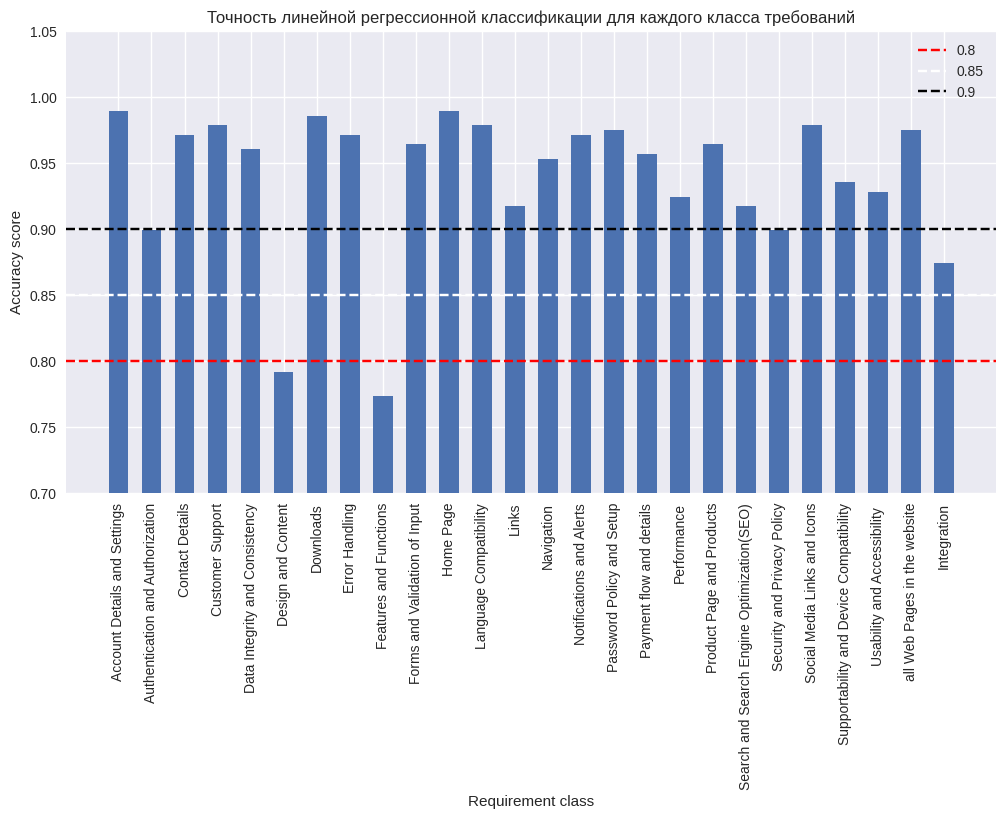

In [57]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(requirement_classes,lr_accuracy_test.values(), width=0.6)
plt.title('Точность линейной регрессионной классификации для каждого класса требований')
a = plt.xticks(rotation=90)
plt.axhline(0.8,c='r',linestyle='--',label='0.8')
plt.axhline(0.85,c='w',linestyle='--',label='0.85')
plt.axhline(0.9,c='black',linestyle='--',label='0.9')
plt.ylim(0.7, 1.05) # adjust y axis limits
plt.legend()
plt.xlabel('Requirement class')
plt.ylabel('Accuracy score')
plt.show()

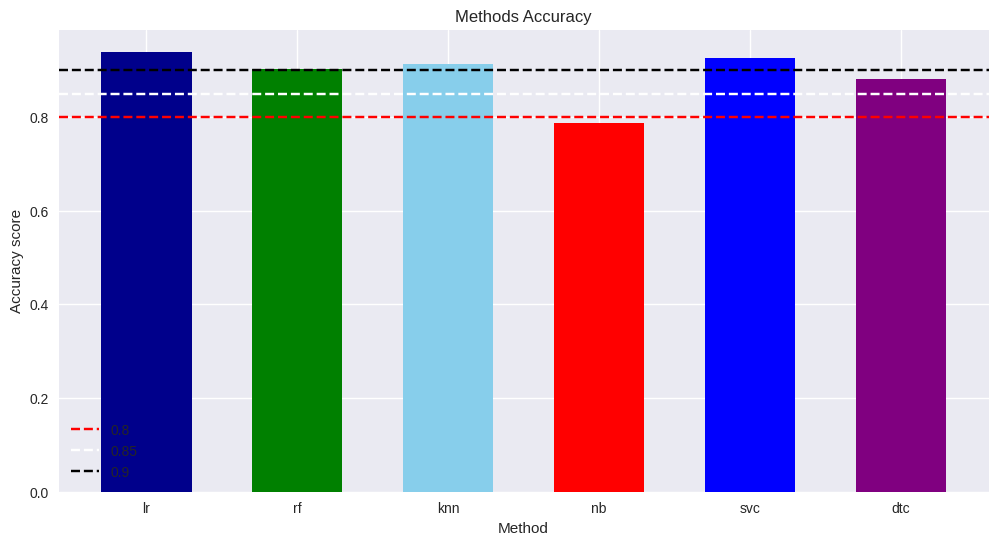

In [58]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers,mean_test_accuracy.values(),width=0.6, color={'red','green','blue','purple', 'skyblue','darkblue'})
plt.title('Methods Accuracy')
plt.axhline(0.8,c='r',linestyle='--',label='0.8')
plt.axhline(0.85,c='w',linestyle='--',label='0.85')
plt.axhline(0.9,c='black',linestyle='--',label='0.9')
plt.legend()
plt.autoscale()
plt.xlabel('Method')
plt.ylabel('Accuracy score')
plt.show()

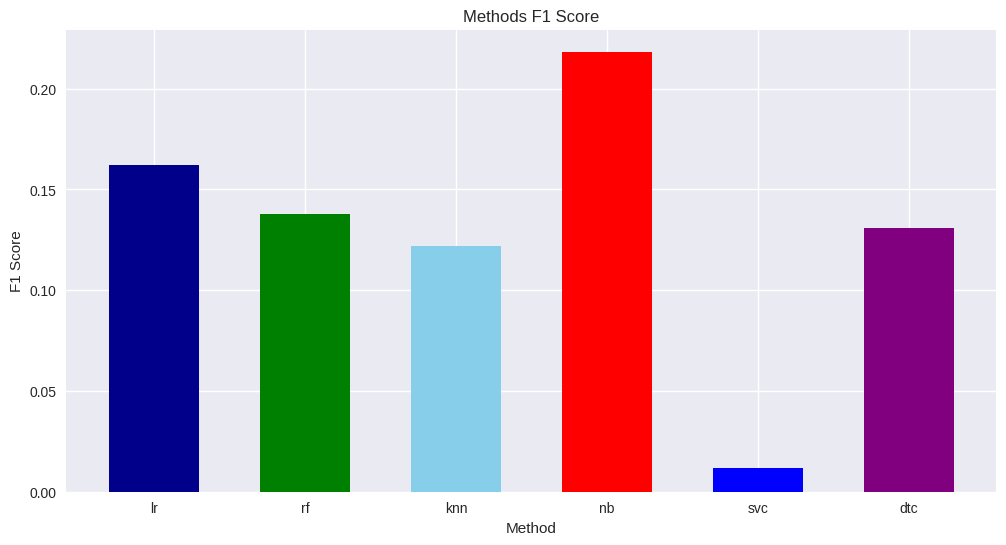

In [59]:
plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers, f1_metrics.values(), width=0.6, color={'red','green','blue','purple', 'skyblue','darkblue'})
plt.title('Methods F1 Score')
plt.legend()
plt.autoscale()
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.show()


In [60]:
print ('method', '\t', 'train accuracy', '\t', 'test accuracy', '\n')
for i in classifiers:
    print (i, '\t', mean_train_accuracy[i], '\t', mean_test_accuracy[i])

method 	 train accuracy 	 test accuracy 

lr 	 0.9396098505810737 	 0.939263973436635
rf 	 0.9048146098505813 	 0.9030160486995018
knn 	 0.9113516878804648 	 0.9138074156059767
nb 	 0.7811635307138902 	 0.7866629773104593
svc 	 0.9262244050913112 	 0.9258439402324292
dtc 	 0.880049806308799 	 0.8815716657443277


#CountVectorizer model



In [61]:
#@title graph visualisation function for metrics

def plot_scores_f1_accuracy(requirement_classes, f1_score, scores, number_of_requirements_per_class):
    # Sort the F1-scores and number of requirements based on the F1-scores in descending order
    sorted_indices = np.argsort(list(f1_score.values()))[::-1]
    sorted_f1_scores = [list(f1_score.values())[i] for i in sorted_indices]
    sorted_class_requirements = [number_of_requirements_per_class[i] for i in sorted_indices]
    sorted_requirement_classes = [requirement_classes[i] for i in sorted_indices]
    sorted_accuracy_scores = [scores[cl] for cl in sorted_requirement_classes]

    # Normalize the F1-scores and accuracy scores between 0 and 1

    normalized_f1_scores = [score for score in sorted_f1_scores]
    normalized_accuracy_scores = [score for score in sorted_accuracy_scores]

    # Set the width of the bars
    bar_width = 0.4

    # Set the x positions for the bars
    x = np.arange(len(sorted_requirement_classes))

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot the F1-scores
    ax1.bar(x, normalized_f1_scores, width=bar_width, label='F1-score', color='blue')

    # Set the y-axis labels for F1-scores
    ax1.set_ylabel('F1-score')
    ax1.legend(loc='upper center')

    # Create a secondary y-axis for the number of requirements
    ax2 = ax1.twinx()
    ax2.plot(x, sorted_class_requirements, color='orange', linestyle='', marker='o', label='Number of Requirements')
    #ax2.set_ylabel('Number of Requirements')
    ax2.legend(loc='upper right')
    ax2.yaxis.set_ticks([])  # Remove y-axis ticks for number of requirements

    # Add the accuracy score as a separate bar chart
    ax3 = ax1.twinx()
    ax3.bar(x + bar_width, normalized_accuracy_scores, width=bar_width, label='Accuracy', color='green', alpha=0.5)
    ax3.set_ylabel('Accuracy')
    ax3.legend(loc='center right')

    # Set the chart title
    ax1.set_title('F1-score, Accuracy, and Number of Requirements for each Requirement Class')
    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_requirement_classes, rotation=90)

    pad = 1.2  #@param {type:"slider", min:1.00, max:2.00, step:0.1}
    plt.tight_layout(pad=pad)
    # Display the chart
    plt.show()


In [62]:
#@title train test split with the help of function split_train_test

X_class_train = dict()
X_class_test = dict()
y_class_train = dict()
y_class_test = dict()

class_requirements = [len(data[data[cl] == 1]) for cl in requirement_classes]

for cl in requirement_classes:
    X_class_train[cl],X_class_test[cl],y_class_train[cl],y_class_test[cl]=split_train_test(dataframe_=data, target_=cl, features_='lemmatized_requirement')

In [63]:
#@title initialize and transform CountVectorizers for each classification task
# Initialize a CountVectorizer object: count_vectorizer
count_train = dict()
count_test = dict()
count_vectorizers = dict()


for cl in requirement_classes:

  count_vectorizers[cl] = CountVectorizer(stop_words="english")
  
  # Transform the training data using only the 'text' column values: count_train 
  count_train[cl] = count_vectorizers[cl].fit_transform(X_class_train[cl])

  # Transform the test data using only the 'text' column values: count_test 
  count_test[cl] = count_vectorizers[cl].transform(X_class_test[cl])

###Naive Bias classifier

In [64]:
# Initialize a dictionary to store naive bias classifiers
nb_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Multinomial Naive Bayes classifier for the current task
    nb_classifier = MultinomialNB()
  
    # Fit the classifier to the training data for the current task
    nb_classifier.fit(count_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    nb_classifiers[cl] = nb_classifier

# Create a dictionary to store predicted tags for each classification task
nb_pred = {}

# Create a dictionary to store accuracy scores for each classification task
nb_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
nb_precision = {}
nb_recall = {}
nb_f1_score = {}
nb_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Predict the tags for the test data of the current task
    nb_pred[cl] = nb_classifiers[cl].predict(count_test[cl])
  
    # Calculate the accuracy score for the current task
    nb_scores[cl] = metrics.accuracy_score(y_class_test[cl], nb_pred[cl])
    print("Accuracy score for", cl, ":", nb_scores[cl])

    # Calculate the confusion matrix for the current task
    nb_cms[cl] = metrics.confusion_matrix(y_class_test[cl], nb_pred[cl], labels=[1, 0])
    print("Confusion matrix for", cl, ":\n", nb_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    nb_precision[cl] = metrics.precision_score(y_class_test[cl], nb_pred[cl])
    nb_recall[cl] = metrics.recall_score(y_class_test[cl], nb_pred[cl])
    nb_f1_score[cl] = metrics.f1_score(y_class_test[cl], nb_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", f1_score[cl], '\n')

Accuracy score for Account Details and Settings : 0.9820143884892086
Confusion matrix for Account Details and Settings :
 [[  0   4]
 [  1 273]]
Accuracy score for Authentication and Authorization : 0.9136690647482014
Confusion matrix for Authentication and Authorization :
 [[ 11  17]
 [  7 243]]
Accuracy score for Contact Details : 0.9784172661870504
Confusion matrix for Contact Details :
 [[  2   5]
 [  1 270]]
Accuracy score for Customer Support : 0.9820143884892086
Confusion matrix for Customer Support :
 [[  1   5]
 [  0 272]]
Accuracy score for Data Integrity and Consistency : 0.960431654676259
Confusion matrix for Data Integrity and Consistency :
 [[  5   5]
 [  6 262]]
Accuracy score for Design and Content : 0.841726618705036
Confusion matrix for Design and Content :
 [[ 32  26]
 [ 18 202]]
Accuracy score for Downloads : 0.9856115107913669
Confusion matrix for Downloads :
 [[  1   4]
 [  0 273]]
Accuracy score for Error Handling : 0.9856115107913669
Confusion matrix for Error H

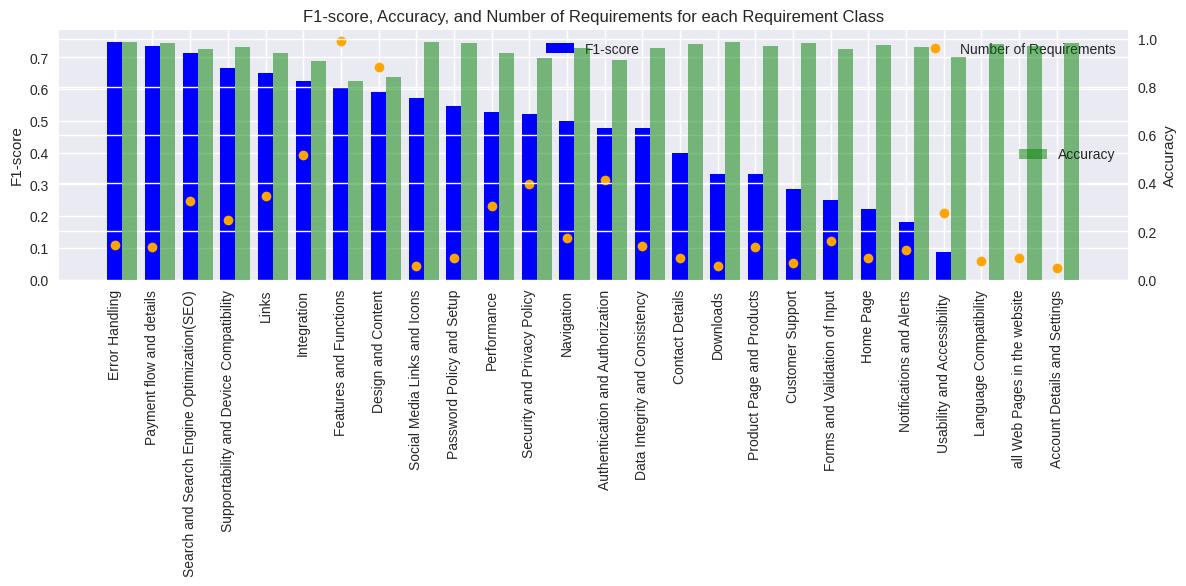

In [65]:
plot_scores_f1_accuracy(requirement_classes, nb_f1_score, nb_scores, class_requirements)

In [66]:
'''#@title graph naive bias F1-score and Number of Requirements for each Requirement Class

# Sort the F1-scores and number of requirements based on the F1-scores in descending order
sorted_indices = np.argsort(list(nb_f1_score.values()))[::-1]
sorted_f1_scores = [list(nb_f1_score.values())[i] for i in sorted_indices]
sorted_class_requirements = [class_requirements[i] for i in sorted_indices]
sorted_requirement_classes = [requirement_classes[i] for i in sorted_indices]
sorted_accuracy_scores = [nb_scores[cl] for cl in sorted_requirement_classes]

# Set the width of the bars
bar_width = 0.4

# Set the x positions for the bars
x = np.arange(len(sorted_requirement_classes))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the F1-scores
ax1.bar(x, sorted_f1_scores, width=bar_width, label='F1-score', color='blue')

# Set the y-axis labels for F1-scores
ax1.set_ylabel('F1-score')
ax1.legend(loc='upper left')

# Create a secondary y-axis for the number of requirements
ax2 = ax1.twinx()
ax2.plot(x, sorted_class_requirements, color='orange', linestyle='', marker='o', label='Number of Requirements')
ax2.set_ylabel('Number of Requirements')
ax2.legend(loc='upper right')

# Set the x-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(sorted_requirement_classes, rotation=90)

# Add the accuracy score as a separate bar chart
ax3 = ax1.twinx()
ax3.bar(x + bar_width, sorted_accuracy_scores, width=bar_width, label='Accuracy', color='green', alpha=0.5)
ax3.set_ylabel('Accuracy')
ax3.legend(loc='upper center')

# Set the chart title
ax1.set_title('F1-score, Accuracy, and Number of Requirements for each Requirement Class')

# Display the chart
plt.show()'''


"#@title graph naive bias F1-score and Number of Requirements for each Requirement Class\n\n# Sort the F1-scores and number of requirements based on the F1-scores in descending order\nsorted_indices = np.argsort(list(nb_f1_score.values()))[::-1]\nsorted_f1_scores = [list(nb_f1_score.values())[i] for i in sorted_indices]\nsorted_class_requirements = [class_requirements[i] for i in sorted_indices]\nsorted_requirement_classes = [requirement_classes[i] for i in sorted_indices]\nsorted_accuracy_scores = [nb_scores[cl] for cl in sorted_requirement_classes]\n\n# Set the width of the bars\nbar_width = 0.4\n\n# Set the x positions for the bars\nx = np.arange(len(sorted_requirement_classes))\n\n# Create a figure and axis\nfig, ax1 = plt.subplots(figsize=(12, 6))\n\n# Plot the F1-scores\nax1.bar(x, sorted_f1_scores, width=bar_width, label='F1-score', color='blue')\n\n# Set the y-axis labels for F1-scores\nax1.set_ylabel('F1-score')\nax1.legend(loc='upper left')\n\n# Create a secondary y-axis for 

###Logistic regression classifier

In [67]:
# Initialize a dictionary to store linear regression classifiers
lr_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a linear regression classifier for the current task
    lr_classifier = LogisticRegression()
  
    # Fit the classifier to the training data for the current task
    lr_classifier.fit(count_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    lr_classifiers[cl] = lr_classifier

# Create a dictionary to store predicted tags for each classification task
lr_pred = {}

# Create a dictionary to store accuracy scores for each classification task
lr_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
lr_precision = {}
lr_recall = {}
lr_f1_score = {}
lr_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Predict the tags for the test data of the current task
    lr_pred[cl] = lr_classifiers[cl].predict(count_test[cl])
  
    # Calculate the accuracy score for the current task
    lr_scores[cl] = metrics.accuracy_score(y_class_test[cl], lr_pred[cl])
    #print("Accuracy score for", cl, ":", lr_scores[cl])

    # Calculate the confusion matrix for the current task
    lr_cms[cl] = metrics.confusion_matrix(y_class_test[cl], lr_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", lr_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    lr_precision[cl] = metrics.precision_score(y_class_test[cl], lr_pred[cl])
    lr_recall[cl] = metrics.recall_score(y_class_test[cl], lr_pred[cl])
    lr_f1_score[cl] = metrics.f1_score(y_class_test[cl], lr_pred[cl])
    
    #print("Precision for", cl, ":", lr_precision[cl])
    #print("Recall for", cl, ":", lr_recall[cl])
    #print("F1-score for", cl, ":", lr_f1_score[cl], '\n')


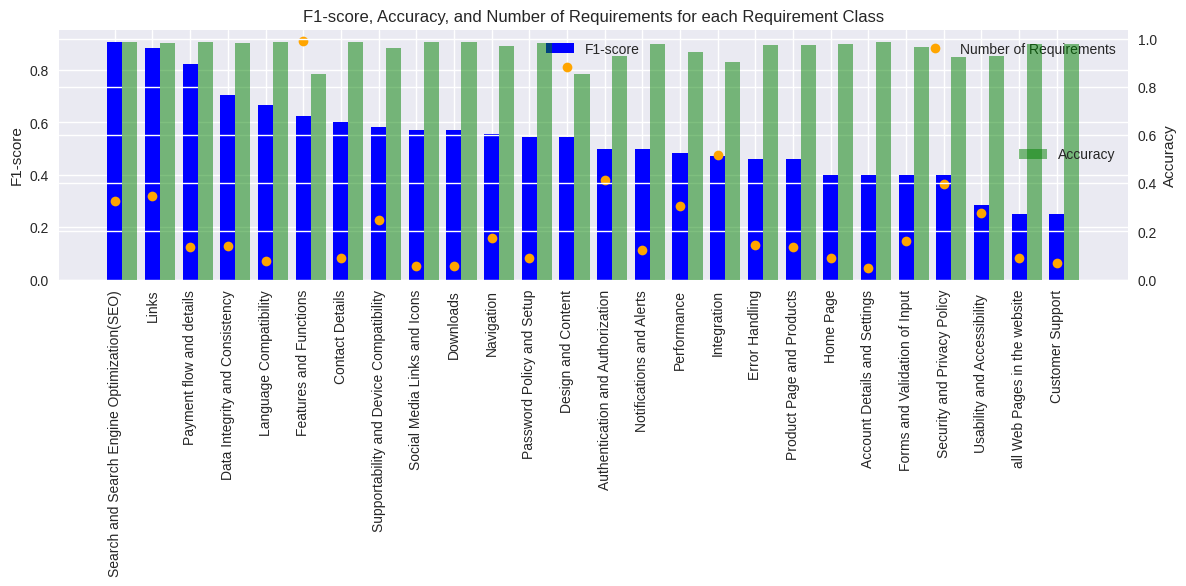

In [68]:
plot_scores_f1_accuracy(requirement_classes, lr_f1_score, lr_scores, class_requirements)

###Random Forest

In [69]:
# Initialize a dictionary to store Random Forest classifiers
rf_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Random Forest classifier for the current task
    rf_classifier = RandomForestClassifier()
  
    # Fit the classifier to the training data for the current task
    rf_classifier.fit(count_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    rf_classifiers[cl] = rf_classifier

# Create a dictionary to store predicted tags for each classification task
rf_pred = {}

# Create a dictionary to store accuracy scores for each classification task
rf_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
rf_precision = {}
rf_recall = {}
rf_f1_score = {}
rf_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Predict the tags for the test data of the current task
    rf_pred[cl] = rf_classifiers[cl].predict(count_test[cl])
  
    # Calculate the accuracy score for the current task
    rf_scores[cl] = metrics.accuracy_score(y_class_test[cl], rf_pred[cl])
    #print("Accuracy score for", cl, ":", rf_scores[cl])

    # Calculate the confusion matrix for the current task
    rf_cms[cl] = metrics.confusion_matrix(y_class_test[cl], rf_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", rf_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    rf_precision[cl] = metrics.precision_score(y_class_test[cl], rf_pred[cl])
    rf_recall[cl] = metrics.recall_score(y_class_test[cl], rf_pred[cl])
    rf_f1_score[cl] = metrics.f1_score(y_class_test[cl], rf_pred[cl])

    # Print precision, recall, and F1-score for the current task
    #print("Precision for", cl, ":", rf_precision[cl])
    #print("Recall for", cl, ":", rf_recall[cl])
    #print("F1-score for", cl, ":", rf_f1_score[cl], '\n')


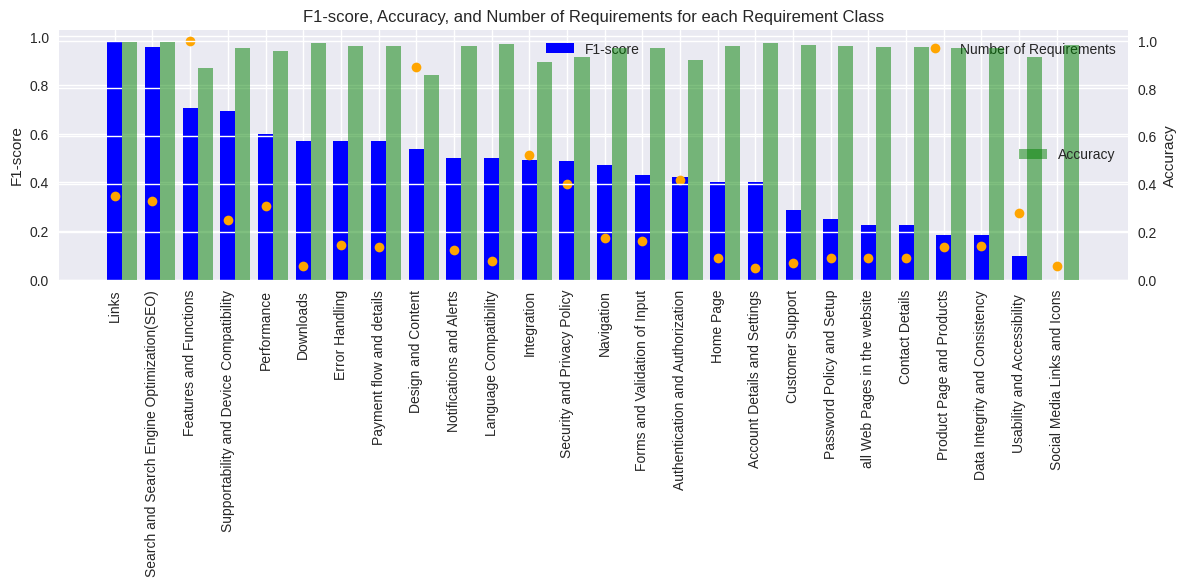

In [70]:
#@title CountVectorizer F1-score and Number of Requirements for each Requirement Class

plot_scores_f1_accuracy(requirement_classes, rf_f1_score, rf_scores, class_requirements)


###KNN

In [71]:
# Initialize a dictionary to store KNN classifiers
knn_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a KNN classifier for the current task
    knn_classifier = KNeighborsClassifier()
  
    # Fit the classifier to the training data for the current task
    knn_classifier.fit(count_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    knn_classifiers[cl] = knn_classifier

# Create a dictionary to store predicted tags for each classification task
knn_pred = {}

# Create a dictionary to store accuracy scores for each classification task
knn_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
knn_precision = {}
knn_recall = {}
knn_f1_score = {}
knn_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Predict the tags for the test data of the current task
    knn_pred[cl] = knn_classifiers[cl].predict(count_test[cl])
  
    # Calculate the accuracy score for the current task
    knn_scores[cl] = metrics.accuracy_score(y_class_test[cl], knn_pred[cl])
    print("Accuracy score for", cl, ":", knn_scores[cl])

    # Calculate the confusion matrix for the current task
    knn_cms[cl] = metrics.confusion_matrix(y_class_test[cl], knn_pred[cl], labels=[1, 0])
    print("Confusion matrix for", cl, ":\n", knn_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    knn_precision[cl] = metrics.precision_score(y_class_test[cl], knn_pred[cl])
    knn_recall[cl] = metrics.recall_score(y_class_test[cl], knn_pred[cl])
    knn_f1_score[cl] = metrics.f1_score(y_class_test[cl], knn_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", f1_score[cl], '\n')


Accuracy score for Account Details and Settings : 0.9856115107913669
Confusion matrix for Account Details and Settings :
 [[  0   4]
 [  0 274]]
Accuracy score for Authentication and Authorization : 0.9100719424460432
Confusion matrix for Authentication and Authorization :
 [[  5  23]
 [  2 248]]
Accuracy score for Contact Details : 0.9856115107913669
Confusion matrix for Contact Details :
 [[  3   4]
 [  0 271]]
Accuracy score for Customer Support : 0.9784172661870504
Confusion matrix for Customer Support :
 [[  0   6]
 [  0 272]]
Accuracy score for Data Integrity and Consistency : 0.9712230215827338
Confusion matrix for Data Integrity and Consistency :
 [[  3   7]
 [  1 267]]
Accuracy score for Design and Content : 0.8057553956834532
Confusion matrix for Design and Content :
 [[ 21  37]
 [ 17 203]]
Accuracy score for Downloads : 0.9820143884892086
Confusion matrix for Downloads :
 [[  0   5]
 [  0 273]]
Accuracy score for Error Handling : 0.9676258992805755
Confusion matrix for Error

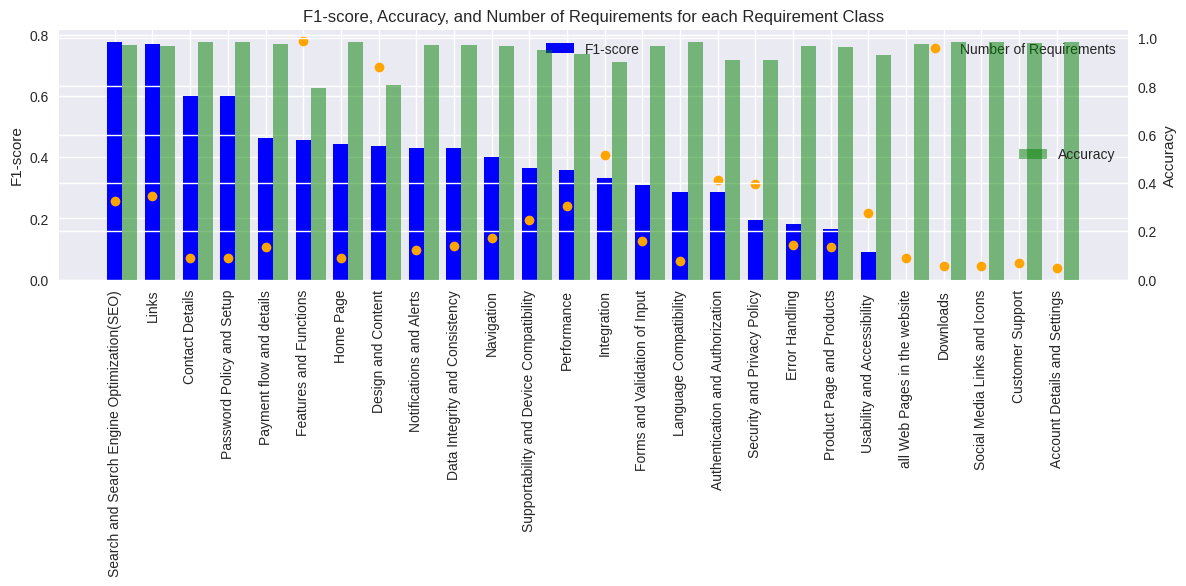

In [72]:
plot_scores_f1_accuracy(requirement_classes, knn_f1_score, knn_scores, class_requirements)

###Decision Tree

In [73]:
# Initialize a dictionary to store Decision Tree classifiers
dtc_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Decision Tree classifier for the current task
    dtc_classifier = DecisionTreeClassifier()
  
    # Fit the classifier to the training data for the current task
    dtc_classifier.fit(count_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    dtc_classifiers[cl] = dtc_classifier

# Create a dictionary to store predicted tags for each classification task
dtc_pred = {}

# Create a dictionary to store accuracy scores for each classification task
dtc_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
dtc_precision = {}
dtc_recall = {}
dtc_f1_score = {}
dtc_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Predict the tags for the test data of the current task
    dtc_pred[cl] = dtc_classifiers[cl].predict(count_test[cl])
  
    # Calculate the accuracy score for the current task
    dtc_scores[cl] = metrics.accuracy_score(y_class_test[cl], dtc_pred[cl])
    print("Accuracy score for", cl, ":", dtc_scores[cl])

    # Calculate the confusion matrix for the current task
    dtc_cms[cl] = metrics.confusion_matrix(y_class_test[cl], dtc_pred[cl], labels=[1, 0])
    print("Confusion matrix for", cl, ":\n", dtc_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    dtc_precision[cl] = metrics.precision_score(y_class_test[cl], dtc_pred[cl])
    dtc_recall[cl] = metrics.recall_score(y_class_test[cl], dtc_pred[cl])
    dtc_f1_score[cl] = metrics.f1_score(y_class_test[cl], dtc_pred[cl])

Accuracy score for Account Details and Settings : 0.9820143884892086
Confusion matrix for Account Details and Settings :
 [[  2   2]
 [  3 271]]
Accuracy score for Authentication and Authorization : 0.920863309352518
Confusion matrix for Authentication and Authorization :
 [[ 14  14]
 [  8 242]]
Accuracy score for Contact Details : 0.9856115107913669
Confusion matrix for Contact Details :
 [[  5   2]
 [  2 269]]
Accuracy score for Customer Support : 0.9892086330935251
Confusion matrix for Customer Support :
 [[  4   2]
 [  1 271]]
Accuracy score for Data Integrity and Consistency : 0.9568345323741008
Confusion matrix for Data Integrity and Consistency :
 [[  2   8]
 [  4 264]]
Accuracy score for Design and Content : 0.8561151079136691
Confusion matrix for Design and Content :
 [[ 35  23]
 [ 17 203]]
Accuracy score for Downloads : 0.9928057553956835
Confusion matrix for Downloads :
 [[  5   0]
 [  2 271]]
Accuracy score for Error Handling : 0.9820143884892086
Confusion matrix for Error 

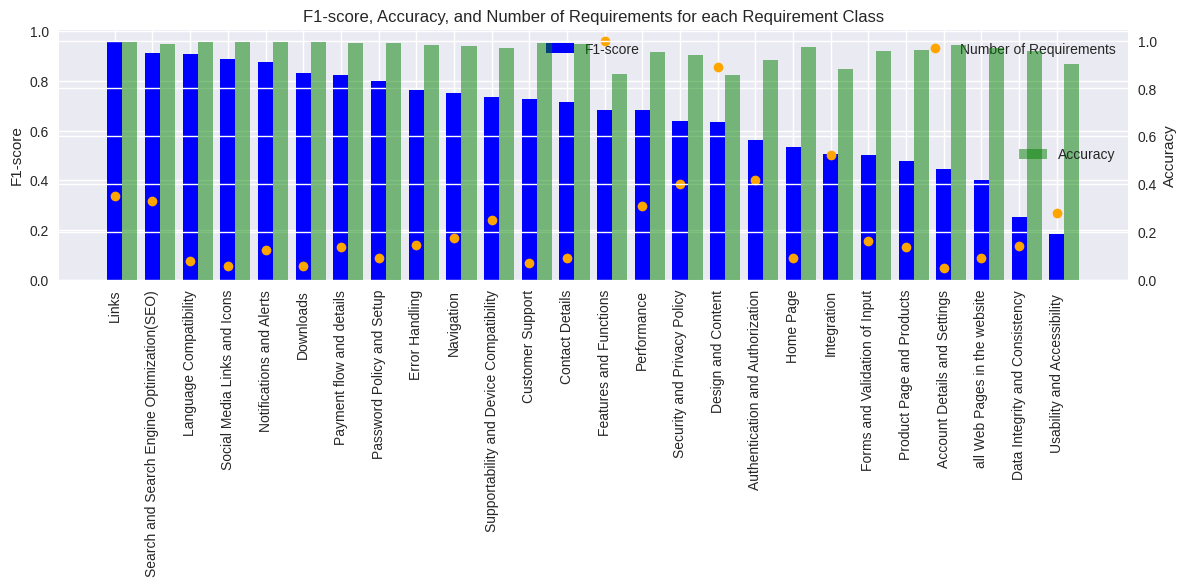

"\nplt.style.use('seaborn')\n\n# Get the number of requirements for each class\ndtc_sorted_f1_score = dict(sorted(dtc_f1_score.items(), key=lambda item: item[1], reverse=True))\n\nfig, ax1 = plt.subplots(figsize=(12, 6))\nbar_width = 0.4\n\n# Plot the F1-score\nax1.bar(dtc_sorted_f1_score.keys(), dtc_sorted_f1_score.values(), width=bar_width, label='F1-score', color='blue')\nax1.set_ylabel('F1-score')\nax1.legend(loc='upper left')\n\nplt.title('F1-score and Number of Requirements for each Requirement Class')\nplt.xlabel('Requirement Class')\nplt.xticks(rotation=90)\n\n# Create a secondary y-axis for number of requirements\nax2 = ax1.twinx()\nax2.plot(requirement_classes, class_requirements, color='orange', linestyle='', marker='o', label='Number of Requirements')\nax2.set_ylabel('Number of Requirements')\nax2.legend(loc='upper right')\n\nplt.show()\n"

In [74]:
#@title graph F1-score and Number of Requirements for each Requirement Class
plot_scores_f1_accuracy(requirement_classes, dtc_f1_score, dtc_scores, class_requirements)
'''
plt.style.use('seaborn')

# Get the number of requirements for each class
dtc_sorted_f1_score = dict(sorted(dtc_f1_score.items(), key=lambda item: item[1], reverse=True))

fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.4

# Plot the F1-score
ax1.bar(dtc_sorted_f1_score.keys(), dtc_sorted_f1_score.values(), width=bar_width, label='F1-score', color='blue')
ax1.set_ylabel('F1-score')
ax1.legend(loc='upper left')

plt.title('F1-score and Number of Requirements for each Requirement Class')
plt.xlabel('Requirement Class')
plt.xticks(rotation=90)

# Create a secondary y-axis for number of requirements
ax2 = ax1.twinx()
ax2.plot(requirement_classes, class_requirements, color='orange', linestyle='', marker='o', label='Number of Requirements')
ax2.set_ylabel('Number of Requirements')
ax2.legend(loc='upper right')

plt.show()
'''

###SVC

In [75]:
# Import the necessary modules
from sklearn.svm import SVC

# Initialize a dictionary to store SVC classifiers
svc_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate an SVC classifier for the current task
    svc_classifier = SVC()
  
    # Fit the classifier to the training data for the current task
    svc_classifier.fit(count_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    svc_classifiers[cl] = svc_classifier

# Create a dictionary to store predicted tags for each classification task
svc_pred = {}

# Create a dictionary to store accuracy scores for each classification task
svc_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
svc_precision = {}
svc_recall = {}
svc_f1_score = {}
svc_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Predict the tags for the test data of the current task
    svc_pred[cl] = svc_classifiers[cl].predict(count_test[cl])
  
    # Calculate the accuracy score for the current task
    svc_scores[cl] = metrics.accuracy_score(y_class_test[cl], svc_pred[cl])
    print("Accuracy score for", cl, ":", svc_scores[cl])

    # Calculate the confusion matrix for the current task
    svc_cms[cl] = metrics.confusion_matrix(y_class_test[cl], svc_pred[cl], labels=[1, 0])
    print("Confusion matrix for", cl, ":\n", svc_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    svc_precision[cl] = metrics.precision_score(y_class_test[cl], svc_pred[cl])
    svc_recall[cl] = metrics.recall_score(y_class_test[cl], svc_pred[cl])
    svc_f1_score[cl] = metrics.f1_score(y_class_test[cl], svc_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", f1_score[cl], '\n')


Accuracy score for Account Details and Settings : 0.9856115107913669
Confusion matrix for Account Details and Settings :
 [[  0   4]
 [  0 274]]
Accuracy score for Authentication and Authorization : 0.9136690647482014
Confusion matrix for Authentication and Authorization :
 [[  4  24]
 [  0 250]]
Accuracy score for Contact Details : 0.9784172661870504
Confusion matrix for Contact Details :
 [[  1   6]
 [  0 271]]
Accuracy score for Customer Support : 0.9784172661870504
Confusion matrix for Customer Support :
 [[  0   6]
 [  0 272]]
Accuracy score for Data Integrity and Consistency : 0.9640287769784173
Confusion matrix for Data Integrity and Consistency :
 [[  0  10]
 [  0 268]]
Accuracy score for Design and Content : 0.8381294964028777
Confusion matrix for Design and Content :
 [[ 15  43]
 [  2 218]]
Accuracy score for Downloads : 0.9820143884892086
Confusion matrix for Downloads :
 [[  0   5]
 [  0 273]]
Accuracy score for Error Handling : 0.9640287769784173
Confusion matrix for Error

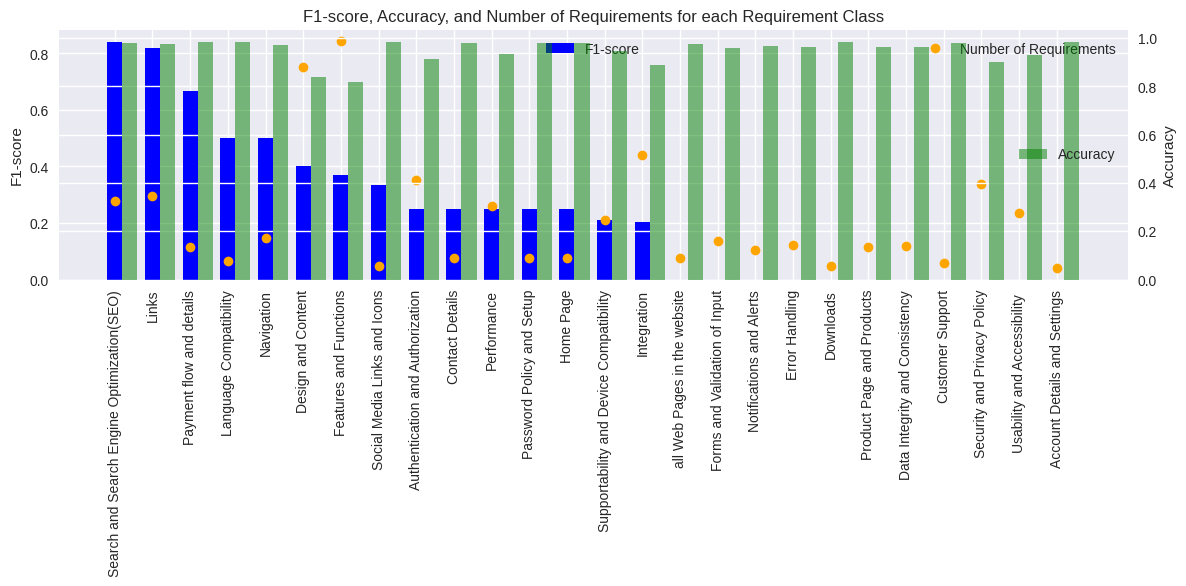

"\nplt.style.use('seaborn')\n\n# Get the number of requirements for each class\nsvc_sorted_f1_score = dict(sorted(svc_f1_score.items(), key=lambda item: item[1], reverse=True))\n\nfig, ax1 = plt.subplots(figsize=(12, 6))\nbar_width = 0.4\n\n# Compute the x-positions for the F1-score bars\nx_f1 = np.arange(len(svc_sorted_f1_score))\n\n# Plot the F1-score bars\nax1.bar(x_f1, svc_sorted_f1_score.values(), width=bar_width, label='F1-score', color='blue')\n\n# Compute the x-positions for the accuracy bars\nx_acc = x_f1 + bar_width\n\n# Plot the accuracy bars\nax1.bar(x_acc, svc_scores.values(), width=bar_width, label='Accuracy score', color='green', alpha=0.5)\n\nax1.set_ylabel('Scores')\nax1.legend(loc='upper left')\n\nplt.title('F1-score and Accuracy Score for each Requirement Class')\nplt.xlabel('Requirement Class')\nplt.xticks(ticks=(x_f1 + bar_width/2), labels=svc_sorted_f1_score.keys(), rotation=90)\n\n# Create a secondary y-axis for number of requirements\n#ax2 = ax1.twinx()\n#ax2.pl

In [76]:
#@title graph F1-score and Accuracy Score for each Requirement Class
plot_scores_f1_accuracy(requirement_classes, svc_f1_score, svc_scores, class_requirements)
'''
plt.style.use('seaborn')

# Get the number of requirements for each class
svc_sorted_f1_score = dict(sorted(svc_f1_score.items(), key=lambda item: item[1], reverse=True))

fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.4

# Compute the x-positions for the F1-score bars
x_f1 = np.arange(len(svc_sorted_f1_score))

# Plot the F1-score bars
ax1.bar(x_f1, svc_sorted_f1_score.values(), width=bar_width, label='F1-score', color='blue')

# Compute the x-positions for the accuracy bars
x_acc = x_f1 + bar_width

# Plot the accuracy bars
ax1.bar(x_acc, svc_scores.values(), width=bar_width, label='Accuracy score', color='green', alpha=0.5)

ax1.set_ylabel('Scores')
ax1.legend(loc='upper left')

plt.title('F1-score and Accuracy Score for each Requirement Class')
plt.xlabel('Requirement Class')
plt.xticks(ticks=(x_f1 + bar_width/2), labels=svc_sorted_f1_score.keys(), rotation=90)

# Create a secondary y-axis for number of requirements
#ax2 = ax1.twinx()
#ax2.plot(svc_sorted_f1_score, class_requirements, color='orange', linestyle='', marker='o', label='Number of Requirements')
#ax2.set_ylabel('Number of Requirements')
#ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
'''

In [77]:
np.mean(list(nb_f1_score.values()))

0.42545566448009786

In [78]:
nb_f1_score

{'Account Details and Settings': 0.0,
 'Authentication and Authorization': 0.4782608695652174,
 'Contact Details': 0.4,
 'Customer Support': 0.2857142857142857,
 'Data Integrity and Consistency': 0.47619047619047616,
 'Design and Content': 0.5925925925925927,
 'Downloads': 0.33333333333333337,
 'Error Handling': 0.7499999999999999,
 'Features and Functions': 0.6065573770491803,
 'Forms and Validation of Input': 0.25000000000000006,
 'Home Page': 0.22222222222222224,
 'Language Compatibility': 0.0,
 'Links': 0.6521739130434783,
 'Navigation': 0.5,
 'Notifications and Alerts': 0.1818181818181818,
 'Password Policy and Setup': 0.5454545454545454,
 'Payment flow and details': 0.7368421052631577,
 'Performance': 0.5294117647058824,
 'Product Page and Products': 0.33333333333333337,
 'Search and Search Engine Optimization(SEO)': 0.7142857142857143,
 'Security and Privacy Policy': 0.5217391304347826,
 'Social Media Links and Icons': 0.5714285714285715,
 'Supportability and Device Compatibilit

##Methods comparison for CountVectorizer

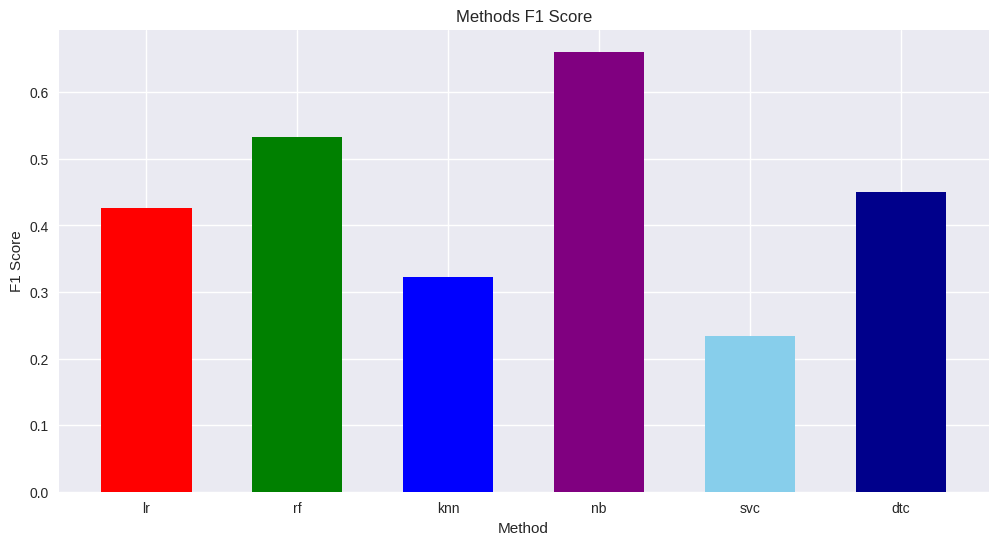

In [79]:
#@title f1_scores
# Create a list to store the F1-scores
f1_metrics = []

# Append the F1-scores for each classifier to the list
f1_metrics.append(list(nb_f1_score.values()))
f1_metrics.append(list(lr_f1_score.values()))
f1_metrics.append(list(knn_f1_score.values()))
f1_metrics.append(list(dtc_f1_score.values()))
f1_metrics.append(list(svc_f1_score.values()))
f1_metrics.append(list(rf_f1_score.values()))

plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers, [np.mean(scores) for scores in f1_metrics], width=0.6, color=['red', 'green', 'blue', 'purple', 'skyblue', 'darkblue'])
plt.title('Methods F1 Score')
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.show()


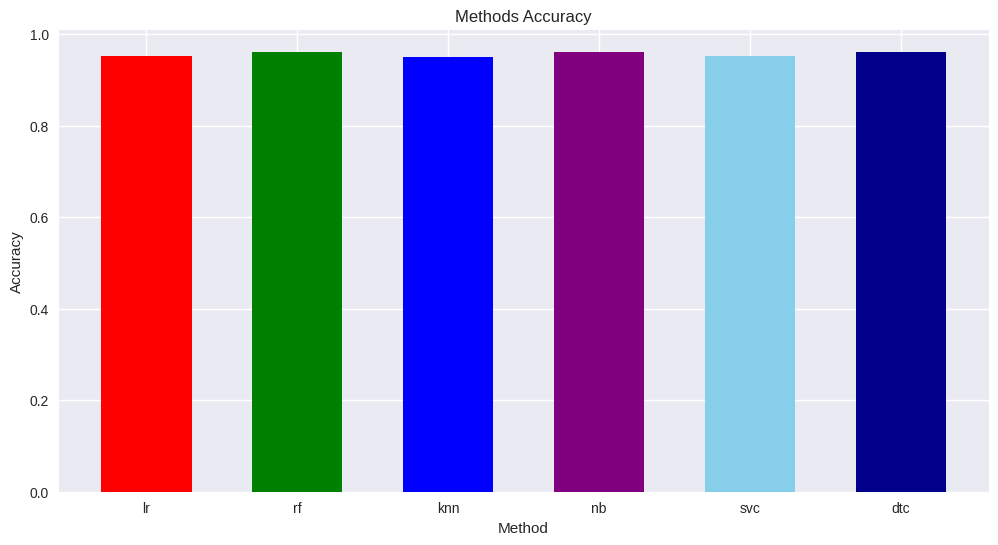

In [80]:
#@title accuracy scores
# Create a list to store the F1-scores
scores_ = []

# Append the F1-scores for each classifier to the list
scores_.append(list(nb_scores.values()))
scores_.append(list(lr_scores.values()))
scores_.append(list(knn_scores.values()))
scores_.append(list(dtc_scores.values()))
scores_.append(list(svc_scores.values()))
scores_.append(list(rf_scores.values()))

plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers, [np.mean(scores) for scores in scores_], width=0.6, color=['red', 'green', 'blue', 'purple', 'skyblue', 'darkblue'])
plt.title('Methods Accuracy')
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.show()


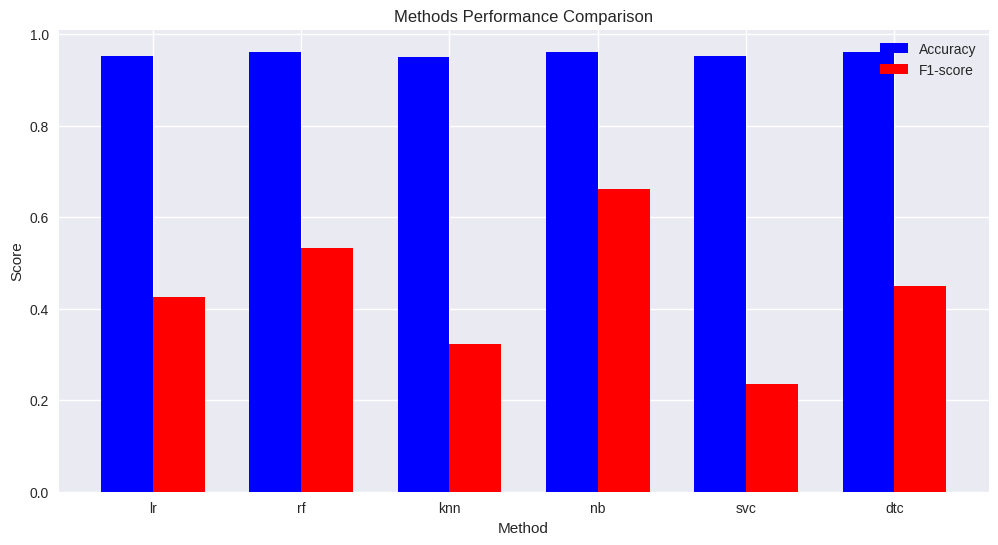

In [81]:
#@title Methods Performance Comparison for CountVectorizer
# Create a list to store the F1-scores
scores_ = []

# Append the F1-scores for each classifier to the list
scores_.append(list(nb_scores.values()))
scores_.append(list(lr_scores.values()))
scores_.append(list(knn_scores.values()))
scores_.append(list(dtc_scores.values()))
scores_.append(list(svc_scores.values()))
scores_.append(list(rf_scores.values()))

# Create a list to store the F1-scores
f1_metrics = []

# Append the F1-scores for each classifier to the list
f1_metrics.append(list(nb_f1_score.values()))
f1_metrics.append(list(lr_f1_score.values()))
f1_metrics.append(list(knn_f1_score.values()))
f1_metrics.append(list(dtc_f1_score.values()))
f1_metrics.append(list(svc_f1_score.values()))
f1_metrics.append(list(rf_f1_score.values()))

bar_width = 0.35
offset = np.arange(len(classifiers))

plt.style.use('seaborn')

plt.figure(figsize=(12, 6))

# Plot the accuracy scores
plt.bar(offset - bar_width/2, [np.mean(scores) for scores in scores_], width=bar_width, label='Accuracy', color='blue')

# Plot the F1-scores
plt.bar(offset + bar_width/2, [np.mean(scores) for scores in f1_metrics], width=bar_width, label='F1-score', color='red')

plt.title('Methods Performance Comparison')
plt.xlabel('Method')
plt.ylabel('Score')
plt.xticks(offset, classifiers)
plt.legend()
plt.show()


#TFIDF Vectorizer

In [82]:
term_max_document_frequency = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}

In [83]:
#@title initialize and transform TfidfVectorizers for each classification task

tfidf_train = dict()
tfidf_test = dict()
tfidf_vectorizers = dict() 

for cl in requirement_classes:

  tfidf_vectorizers[cl] = TfidfVectorizer(stop_words="english", max_df=term_max_document_frequency)
  
  # Transform the training data using only the 'text' column values: count_train 
  tfidf_train[cl] = tfidf_vectorizers[cl].fit_transform(X_class_train[cl])

  # Transform the test data using only the 'text' column values: count_test 
  tfidf_test[cl] = tfidf_vectorizers[cl].transform(X_class_test[cl])

##Naive bias

In [84]:
#@title naive bias classifier for TF-IDF Vectorizer

# Initialize a dictionary to store naive bias classifiers
nb_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Multinomial Naive Bayes classifier for the current task
    nb_classifier = MultinomialNB()

    # Fit the classifier to the training data for the current task
    nb_classifier.fit(tfidf_train[cl], y_class_train[cl])

    # Store the classifier in the dictionary
    nb_classifiers[cl] = nb_classifier

# Create a dictionary to store predicted tags for each classification task
nb_pred = {}

# Create a dictionary to store accuracy scores for each classification task
nb_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
nb_precision = {}
nb_recall = {}
nb_f1_score = {}
nb_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    tfidf_test = tfidf_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    nb_pred[cl] = nb_classifiers[cl].predict(tfidf_test)

    # Calculate the accuracy score for the current task
    nb_scores[cl] = metrics.accuracy_score(y_class_test[cl], nb_pred[cl])
    #print("Accuracy score for", cl, ":", nb_scores[cl])

    # Calculate the confusion matrix for the current task
    nb_cms[cl] = metrics.confusion_matrix(y_class_test[cl], nb_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", nb_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    nb_precision[cl] = metrics.precision_score(y_class_test[cl], nb_pred[cl])
    nb_recall[cl] = metrics.recall_score(y_class_test[cl], nb_pred[cl])
    nb_f1_score[cl] = metrics.f1_score(y_class_test[cl], nb_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", nb_f1_score[cl], '\n')


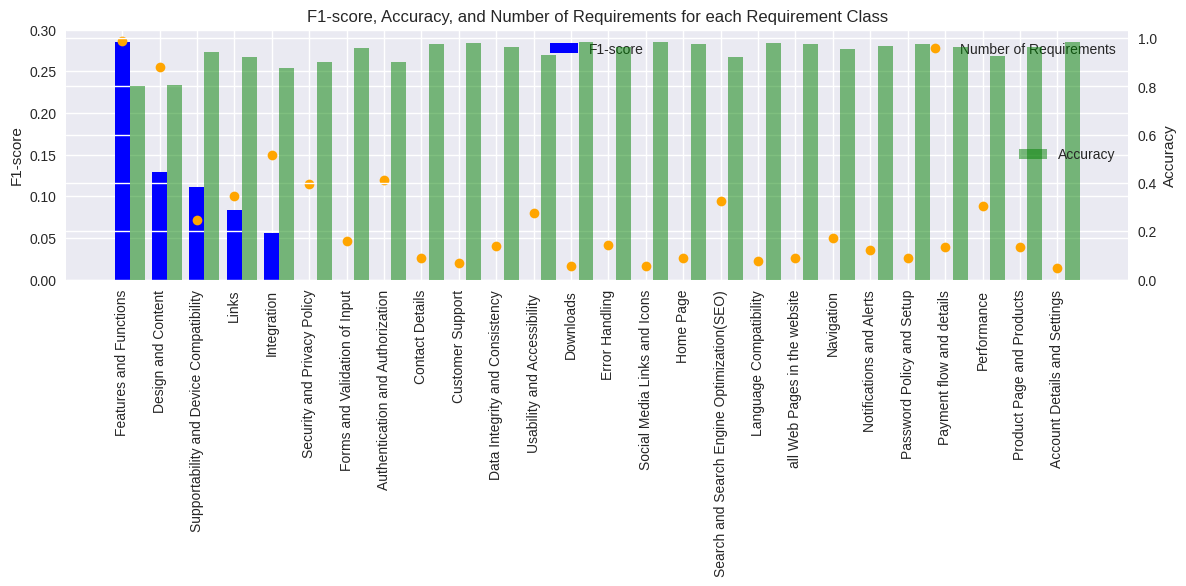

"\n# Sort the F1-scores and number of requirements based on the F1-scores in descending order\nsorted_indices = np.argsort(list(nb_f1_score.values()))[::-1]\nsorted_f1_scores = [list(nb_f1_score.values())[i] for i in sorted_indices]\nsorted_class_requirements = [class_requirements[i] for i in sorted_indices]\nsorted_requirement_classes = [requirement_classes[i] for i in sorted_indices]\n\n# Set the width of the bars\nbar_width = 0.4\n\n# Set the x positions for the bars\nx = np.arange(len(requirement_classes))\n\n# Create a figure and axis\nfig, ax1 = plt.subplots(figsize=(12, 6))\n\n# Plot the F1-scores\nax1.bar(x, sorted_f1_scores, width=bar_width, label='F1-score', color='blue')\n\n# Set the y-axis labels for F1-scores\nax1.set_ylabel('F1-score')\nax1.legend(loc='upper left')\n\n# Create a secondary y-axis for the number of requirements\nax2 = ax1.twinx()\nax2.plot(x, sorted_class_requirements, color='orange', linestyle='', marker='o', label='Number of Requirements')\nax2.set_ylabel

In [85]:
#@title Graph for F1-score of naive bias classifier for TF-IDF Vectorizer

plot_scores_f1_accuracy(requirement_classes, nb_f1_score, nb_scores, class_requirements)

'''
# Sort the F1-scores and number of requirements based on the F1-scores in descending order
sorted_indices = np.argsort(list(nb_f1_score.values()))[::-1]
sorted_f1_scores = [list(nb_f1_score.values())[i] for i in sorted_indices]
sorted_class_requirements = [class_requirements[i] for i in sorted_indices]
sorted_requirement_classes = [requirement_classes[i] for i in sorted_indices]

# Set the width of the bars
bar_width = 0.4

# Set the x positions for the bars
x = np.arange(len(requirement_classes))

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the F1-scores
ax1.bar(x, sorted_f1_scores, width=bar_width, label='F1-score', color='blue')

# Set the y-axis labels for F1-scores
ax1.set_ylabel('F1-score')
ax1.legend(loc='upper left')

# Create a secondary y-axis for the number of requirements
ax2 = ax1.twinx()
ax2.plot(x, sorted_class_requirements, color='orange', linestyle='', marker='o', label='Number of Requirements')
ax2.set_ylabel('Number of Requirements')
ax2.legend(loc='upper right')

# Set the x-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(sorted_requirement_classes, rotation=90)

# Set the chart title
ax1.set_title('F1-score and Number of Requirements for each Requirement Class')

# Display the chart
plt.show()
'''

In [86]:
#@title Graph for F1-score and Accuracy 
'''
# Get the F1-scores and accuracy scores for each class
f1_scores = list(nb_f1_score.values())
accuracy_scores = list(nb_scores.values())

# Set the width of the bars
bar_width = 0.35

# Set the x positions for the bars
x = np.arange(len(requirement_classes))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the F1-scores
ax.bar(x - bar_width/2, f1_scores, width=bar_width, label='F1-score', color='blue')

# Plot the accuracy scores
ax.bar(x + bar_width/2, accuracy_scores, width=bar_width, label='Accuracy', color='green')

# Set the x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(requirement_classes, rotation=90)

# Set the y-axis labels
ax.set_ylabel('Score')

# Set the chart title
ax.set_title('F1-score and Accuracy for each Requirement Class')

# Add a legend
ax.legend()

# Display the chart
plt.show()
'''

"\n# Get the F1-scores and accuracy scores for each class\nf1_scores = list(nb_f1_score.values())\naccuracy_scores = list(nb_scores.values())\n\n# Set the width of the bars\nbar_width = 0.35\n\n# Set the x positions for the bars\nx = np.arange(len(requirement_classes))\n\n# Create a figure and axis\nfig, ax = plt.subplots(figsize=(12, 6))\n\n# Plot the F1-scores\nax.bar(x - bar_width/2, f1_scores, width=bar_width, label='F1-score', color='blue')\n\n# Plot the accuracy scores\nax.bar(x + bar_width/2, accuracy_scores, width=bar_width, label='Accuracy', color='green')\n\n# Set the x-axis labels\nax.set_xticks(x)\nax.set_xticklabels(requirement_classes, rotation=90)\n\n# Set the y-axis labels\nax.set_ylabel('Score')\n\n# Set the chart title\nax.set_title('F1-score and Accuracy for each Requirement Class')\n\n# Add a legend\nax.legend()\n\n# Display the chart\nplt.show()\n"

##Logistic regression

In [87]:
# Initialize a dictionary to store linear regression classifiers
lr_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a linear regression classifier for the current task
    lr_classifier = LogisticRegression()
  
    # Fit the classifier to the training data for the current task
    lr_classifier.fit(tfidf_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    lr_classifiers[cl] = lr_classifier

# Create a dictionary to store predicted tags for each classification task
lr_pred = {}

# Create a dictionary to store accuracy scores for each classification task
lr_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
lr_precision = {}
lr_recall = {}
lr_f1_score = {}
lr_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    
    # Transform the test data using TfidfVectorizer
    tfidf_test = tfidf_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    lr_pred[cl] = lr_classifiers[cl].predict(tfidf_test)
    
    #lr_pred[cl] = lr_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    lr_scores[cl] = metrics.accuracy_score(y_class_test[cl], lr_pred[cl])
    #print("Accuracy score for", cl, ":", lr_scores[cl])

    # Calculate the confusion matrix for the current task
    lr_cms[cl] = metrics.confusion_matrix(y_class_test[cl], lr_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", lr_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    lr_precision[cl] = metrics.precision_score(y_class_test[cl], lr_pred[cl])
    lr_recall[cl] = metrics.recall_score(y_class_test[cl], lr_pred[cl])
    lr_f1_score[cl] = metrics.f1_score(y_class_test[cl], lr_pred[cl])
    
    #print("Precision for", cl, ":", lr_precision[cl])
    #print("Recall for", cl, ":", lr_recall[cl])
    #print("F1-score for", cl, ":", lr_f1_score[cl], '\n')


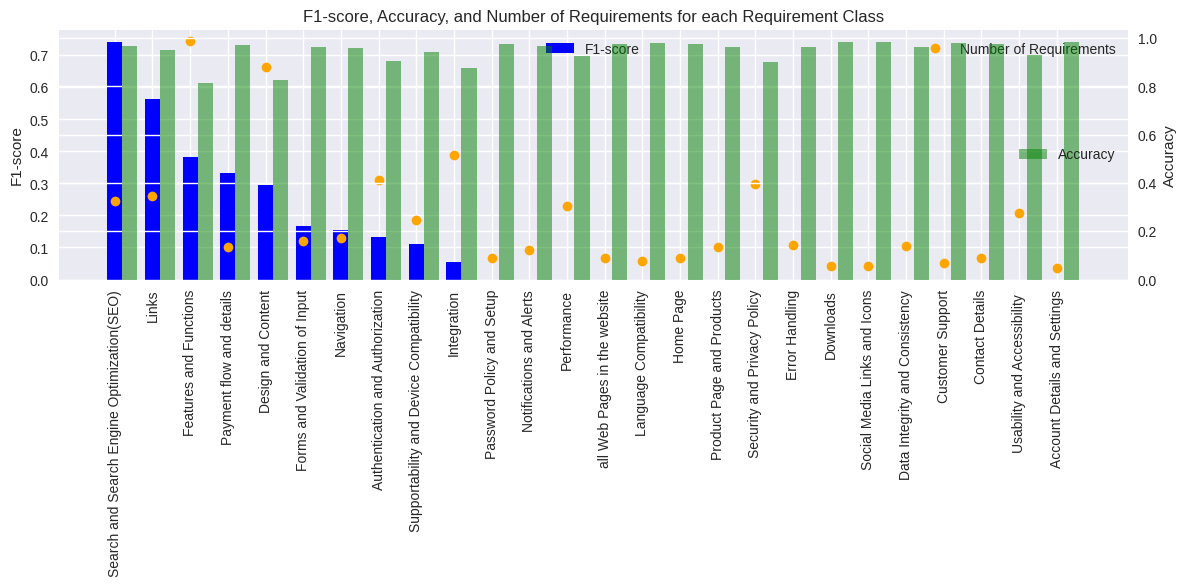

In [88]:
plot_scores_f1_accuracy(requirement_classes, lr_f1_score, lr_scores, class_requirements)

##Random forest

In [89]:
# Initialize a dictionary to store Random Forest classifiers
rf_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Random Forest classifier for the current task
    rf_classifier = RandomForestClassifier()
  
    # Fit the classifier to the training data for the current task
    rf_classifier.fit(tfidf_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    rf_classifiers[cl] = rf_classifier

# Create a dictionary to store predicted tags for each classification task
rf_pred = {}

# Create a dictionary to store accuracy scores for each classification task
rf_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
rf_precision = {}
rf_recall = {}
rf_f1_score = {}
rf_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    tfidf_test = tfidf_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    rf_pred[cl] = rf_classifiers[cl].predict(tfidf_test)
    
    # Predict the tags for the test data of the current task
    #rf_pred[cl] = rf_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    rf_scores[cl] = metrics.accuracy_score(y_class_test[cl], rf_pred[cl])
    #print("Accuracy score for", cl, ":", rf_scores[cl])

    # Calculate the confusion matrix for the current task
    rf_cms[cl] = metrics.confusion_matrix(y_class_test[cl], rf_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", rf_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    rf_precision[cl] = metrics.precision_score(y_class_test[cl], rf_pred[cl])
    rf_recall[cl] = metrics.recall_score(y_class_test[cl], rf_pred[cl])
    rf_f1_score[cl] = metrics.f1_score(y_class_test[cl], rf_pred[cl])

    # Print precision, recall, and F1-score for the current task
    #print("Precision for", cl, ":", rf_precision[cl])
    #print("Recall for", cl, ":", rf_recall[cl])
    #print("F1-score for", cl, ":", rf_f1_score[cl], '\n')


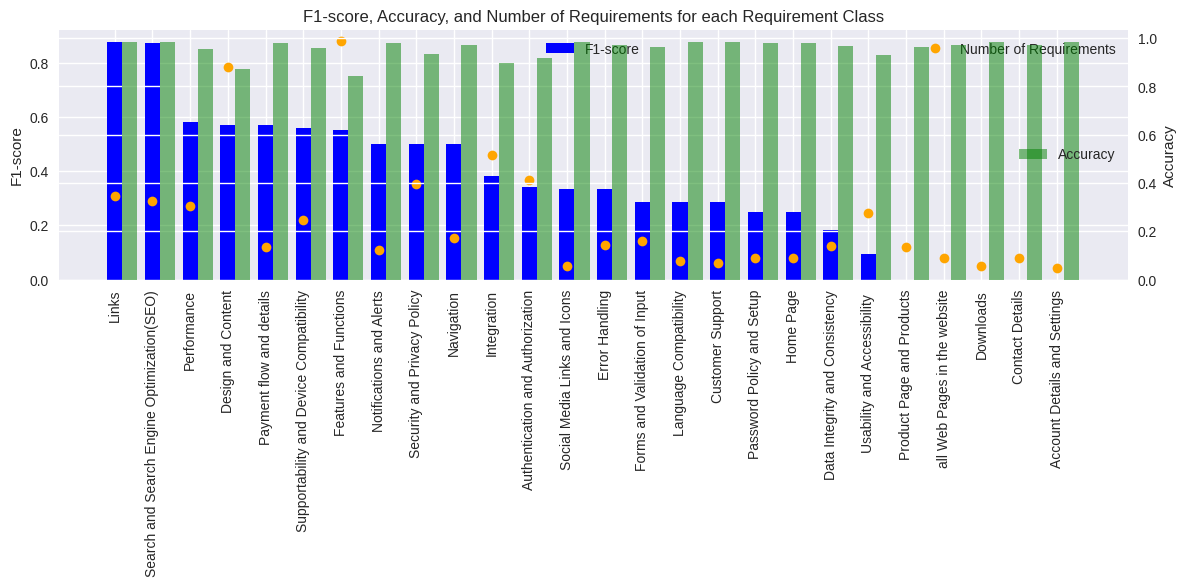

In [90]:
plot_scores_f1_accuracy(requirement_classes, rf_f1_score, rf_scores, class_requirements)

##KNN

In [91]:
# Initialize a dictionary to store KNN classifiers
knn_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a KNN classifier for the current task
    knn_classifier = KNeighborsClassifier()
  
    # Fit the classifier to the training data for the current task
    knn_classifier.fit(tfidf_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    knn_classifiers[cl] = knn_classifier

# Create a dictionary to store predicted tags for each classification task
knn_pred = {}

# Create a dictionary to store accuracy scores for each classification task
knn_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
knn_precision = {}
knn_recall = {}
knn_f1_score = {}
knn_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    tfidf_test = tfidf_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    knn_pred[cl] = knn_classifiers[cl].predict(tfidf_test)
    
    # Predict the tags for the test data of the current task
    #knn_pred[cl] = knn_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    knn_scores[cl] = metrics.accuracy_score(y_class_test[cl], knn_pred[cl])
    #print("Accuracy score for", cl, ":", knn_scores[cl])

    # Calculate the confusion matrix for the current task
    knn_cms[cl] = metrics.confusion_matrix(y_class_test[cl], knn_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", knn_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    knn_precision[cl] = metrics.precision_score(y_class_test[cl], knn_pred[cl])
    knn_recall[cl] = metrics.recall_score(y_class_test[cl], knn_pred[cl])
    knn_f1_score[cl] = metrics.f1_score(y_class_test[cl], knn_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", f1_score[cl], '\n')


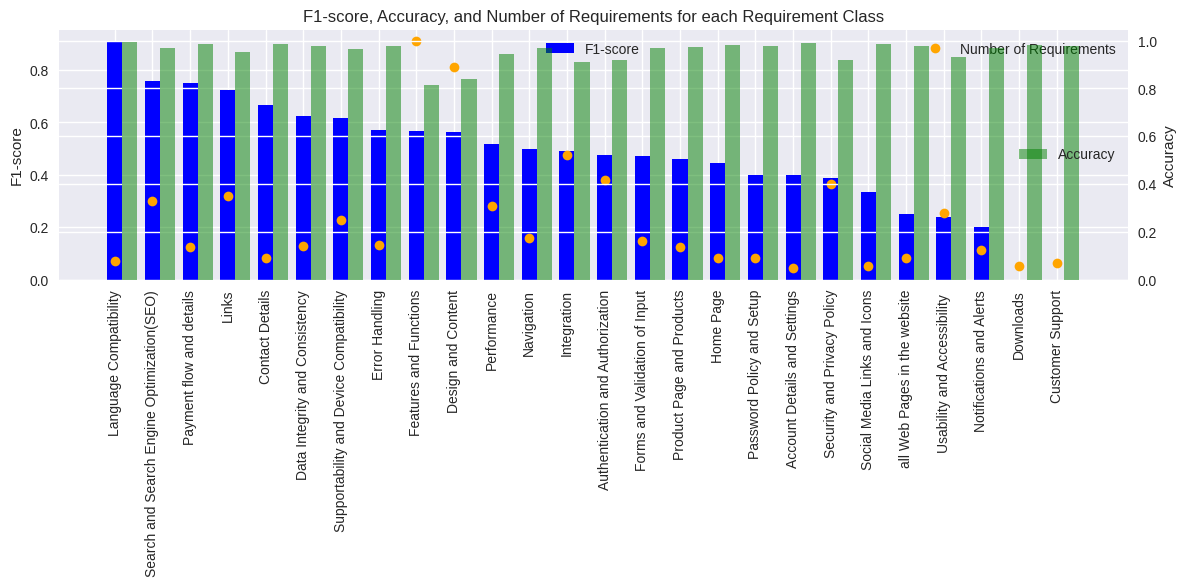

In [92]:
plot_scores_f1_accuracy(requirement_classes, knn_f1_score, knn_scores, class_requirements)

##Decision tree

In [93]:

# Initialize a dictionary to store Decision Tree classifiers
dtc_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Decision Tree classifier for the current task
    dtc_classifier = DecisionTreeClassifier()
  
    # Fit the classifier to the training data for the current task
    dtc_classifier.fit(tfidf_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    dtc_classifiers[cl] = dtc_classifier

# Create a dictionary to store predicted tags for each classification task
dtc_pred = {}

# Create a dictionary to store accuracy scores for each classification task
dtc_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
dtc_precision = {}
dtc_recall = {}
dtc_f1_score = {}
dtc_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    tfidf_test = tfidf_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    dtc_pred[cl] = dtc_classifiers[cl].predict(tfidf_test)

    # Predict the tags for the test data of the current task
    #dtc_pred[cl] = dtc_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    dtc_scores[cl] = metrics.accuracy_score(y_class_test[cl], dtc_pred[cl])
    print("Accuracy score for", cl, ":", dtc_scores[cl])

    # Calculate the confusion matrix for the current task
    dtc_cms[cl] = metrics.confusion_matrix(y_class_test[cl], dtc_pred[cl], labels=[1, 0])
    print("Confusion matrix for", cl, ":\n", dtc_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    dtc_precision[cl] = metrics.precision_score(y_class_test[cl], dtc_pred[cl])
    dtc_recall[cl] = metrics.recall_score(y_class_test[cl], dtc_pred[cl])
    dtc_f1_score[cl] = metrics.f1_score(y_class_test[cl], dtc_pred[cl])

Accuracy score for Account Details and Settings : 0.9784172661870504
Confusion matrix for Account Details and Settings :
 [[  1   3]
 [  3 271]]
Accuracy score for Authentication and Authorization : 0.9136690647482014
Confusion matrix for Authentication and Authorization :
 [[ 14  14]
 [ 10 240]]
Accuracy score for Contact Details : 0.9856115107913669
Confusion matrix for Contact Details :
 [[  6   1]
 [  3 268]]
Accuracy score for Customer Support : 0.9784172661870504
Confusion matrix for Customer Support :
 [[  2   4]
 [  2 270]]
Accuracy score for Data Integrity and Consistency : 0.9460431654676259
Confusion matrix for Data Integrity and Consistency :
 [[  1   9]
 [  6 262]]
Accuracy score for Design and Content : 0.8093525179856115
Confusion matrix for Design and Content :
 [[ 30  28]
 [ 25 195]]
Accuracy score for Downloads : 0.9892086330935251
Confusion matrix for Downloads :
 [[  3   2]
 [  1 272]]
Accuracy score for Error Handling : 0.9820143884892086
Confusion matrix for Error

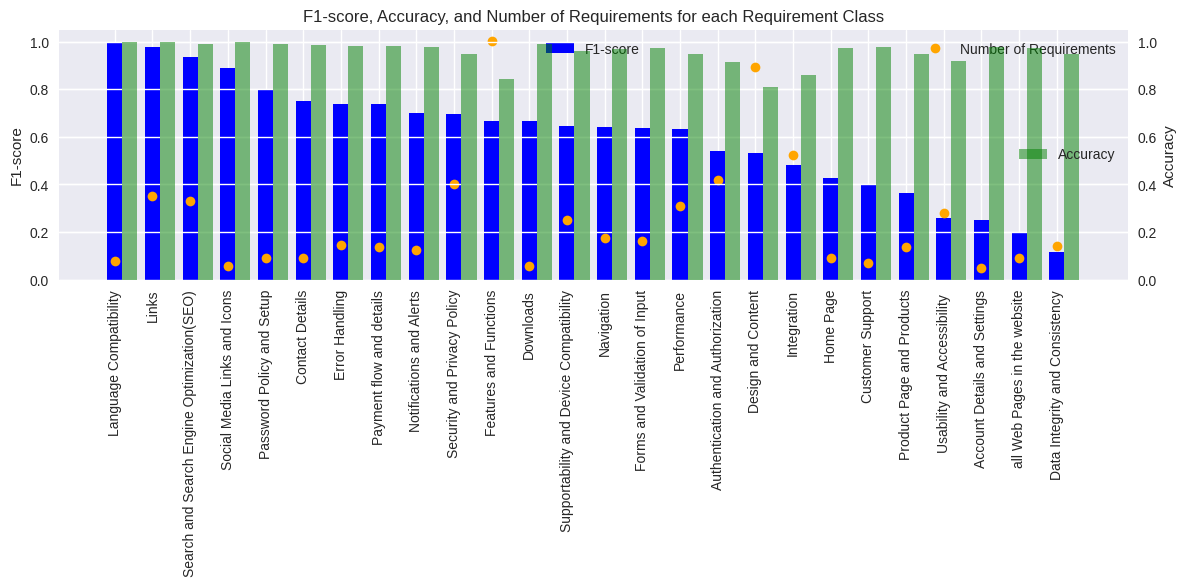

In [94]:
plot_scores_f1_accuracy(requirement_classes, dtc_f1_score, dtc_scores, class_requirements)

##SVC

In [95]:
# Import the necessary modules
from sklearn.svm import SVC

# Initialize a dictionary to store SVC classifiers
svc_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate an SVC classifier for the current task
    svc_classifier = SVC()
  
    # Fit the classifier to the training data for the current task
    svc_classifier.fit(tfidf_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    svc_classifiers[cl] = svc_classifier

# Create a dictionary to store predicted tags for each classification task
svc_pred = {}

# Create a dictionary to store accuracy scores for each classification task
svc_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
svc_precision = {}
svc_recall = {}
svc_f1_score = {}
svc_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    tfidf_test = tfidf_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    svc_pred[cl] = svc_classifiers[cl].predict(tfidf_test)
    # Predict the tags for the test data of the current task
    #svc_pred[cl] = svc_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    svc_scores[cl] = metrics.accuracy_score(y_class_test[cl], svc_pred[cl])
    #print("Accuracy score for", cl, ":", svc_scores[cl])

    # Calculate the confusion matrix for the current task
    svc_cms[cl] = metrics.confusion_matrix(y_class_test[cl], svc_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", svc_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    svc_precision[cl] = metrics.precision_score(y_class_test[cl], svc_pred[cl])
    svc_recall[cl] = metrics.recall_score(y_class_test[cl], svc_pred[cl])
    svc_f1_score[cl] = metrics.f1_score(y_class_test[cl], svc_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", f1_score[cl], '\n')


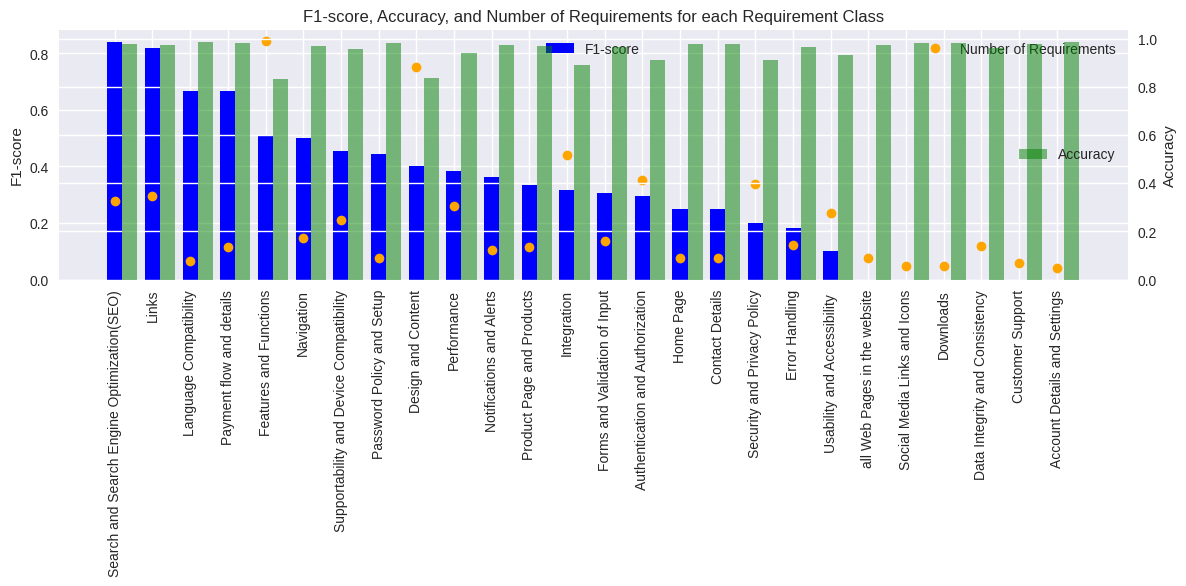

In [96]:
plot_scores_f1_accuracy(requirement_classes, svc_f1_score, svc_scores, class_requirements)

##Methods comparison for TfidfVectorizer

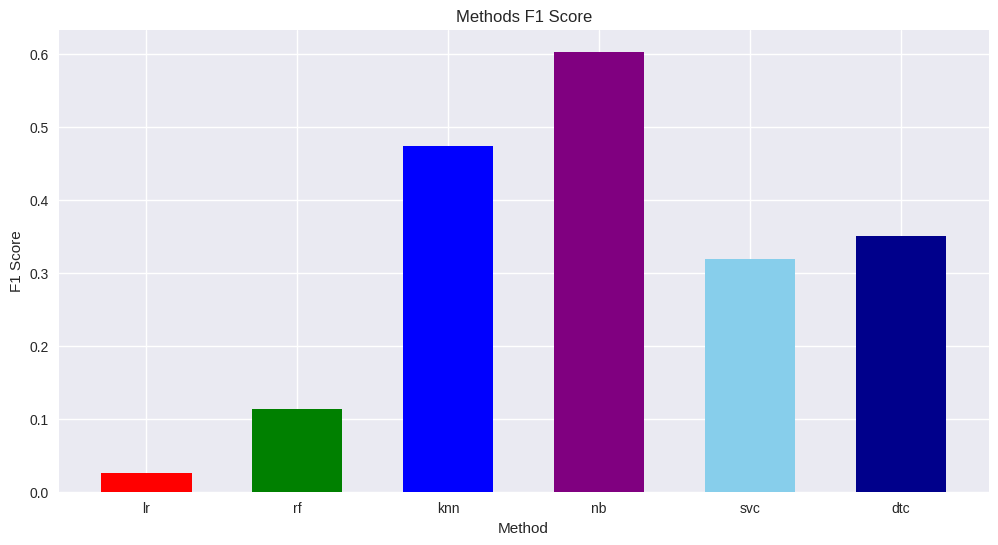

In [97]:
#@title f1_scores
# Create a list to store the F1-scores
f1_metrics = []

# Append the F1-scores for each classifier to the list
f1_metrics.append(list(nb_f1_score.values()))
f1_metrics.append(list(lr_f1_score.values()))
f1_metrics.append(list(knn_f1_score.values()))
f1_metrics.append(list(dtc_f1_score.values()))
f1_metrics.append(list(svc_f1_score.values()))
f1_metrics.append(list(rf_f1_score.values()))

plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers, [np.mean(scores) for scores in f1_metrics], width=0.6, color=['red', 'green', 'blue', 'purple', 'skyblue', 'darkblue'])
plt.title('Methods F1 Score')
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.show()


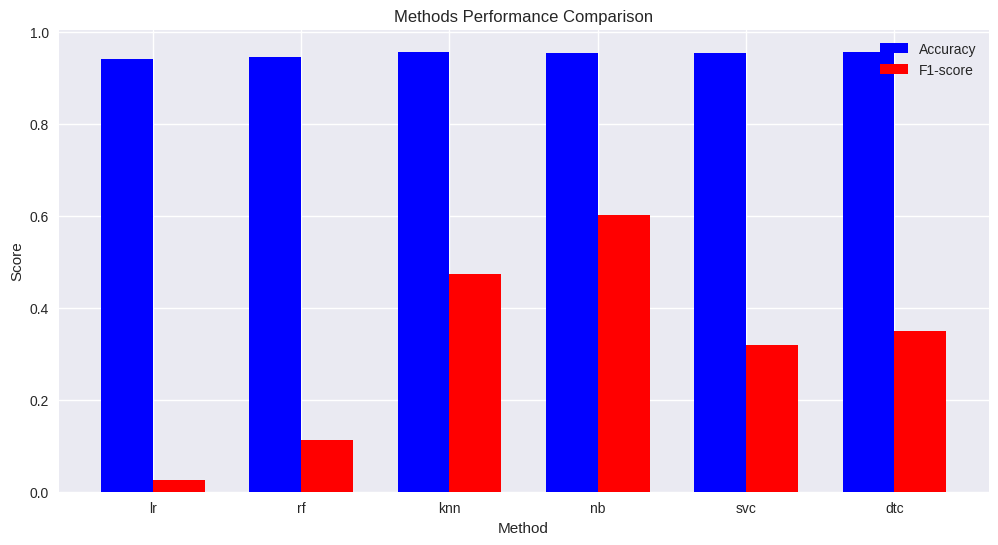

In [98]:
#@title Methods Performance Comparison for CountVectorizer
# Create a list to store the F1-scores
scores_ = []

# Append the F1-scores for each classifier to the list
scores_.append(list(nb_scores.values()))
scores_.append(list(lr_scores.values()))
scores_.append(list(knn_scores.values()))
scores_.append(list(dtc_scores.values()))
scores_.append(list(svc_scores.values()))
scores_.append(list(rf_scores.values()))

# Create a list to store the F1-scores
f1_metrics = []

# Append the F1-scores for each classifier to the list
f1_metrics.append(list(nb_f1_score.values()))
f1_metrics.append(list(lr_f1_score.values()))
f1_metrics.append(list(knn_f1_score.values()))
f1_metrics.append(list(dtc_f1_score.values()))
f1_metrics.append(list(svc_f1_score.values()))
f1_metrics.append(list(rf_f1_score.values()))

bar_width = 0.35
offset = np.arange(len(classifiers))

plt.style.use('seaborn')

plt.figure(figsize=(12, 6))

# Plot the accuracy scores
plt.bar(offset - bar_width/2, [np.mean(scores) for scores in scores_], width=bar_width, label='Accuracy', color='blue')

# Plot the F1-scores
plt.bar(offset + bar_width/2, [np.mean(scores) for scores in f1_metrics], width=bar_width, label='F1-score', color='red')

plt.title('Methods Performance Comparison')
plt.xlabel('Method')
plt.ylabel('Score')
plt.xticks(offset, classifiers)
plt.legend()
plt.show()


#Hashing Vectorizer

In [99]:
'''


tfidf_train = dict()
tfidf_test = dict()
tfidf_vectorizers = dict() 

for cl in requirement_classes:

  tfidf_vectorizers[cl] = TfidfVectorizer(stop_words="english", max_df=term_max_document_frequency)
  
  # Transform the training data using only the 'text' column values: count_train 
  tfidf_train[cl] = tfidf_vectorizers[cl].fit_transform(X_class_train[cl])

  # Transform the test data using only the 'text' column values: count_test 
  tfidf_test[cl] = tfidf_vectorizers[cl].transform(X_class_test[cl])'''

'\n\n\ntfidf_train = dict()\ntfidf_test = dict()\ntfidf_vectorizers = dict() \n\nfor cl in requirement_classes:\n\n  tfidf_vectorizers[cl] = TfidfVectorizer(stop_words="english", max_df=term_max_document_frequency)\n  \n  # Transform the training data using only the \'text\' column values: count_train \n  tfidf_train[cl] = tfidf_vectorizers[cl].fit_transform(X_class_train[cl])\n\n  # Transform the test data using only the \'text\' column values: count_test \n  tfidf_test[cl] = tfidf_vectorizers[cl].transform(X_class_test[cl])'

In [100]:
hv_number_of_features = 2**10 #@param

In [101]:
#@title initialize and transform HashingVectorizers for each classification task

hv_train = dict()
hv_test = dict()
hv_vectorizers = dict() 

for cl in requirement_classes:

    hv_vectorizers[cl] = HashingVectorizer(stop_words="english", n_features= hv_number_of_features)

    # Transform the training data using only the 'text' column values: hash_train
    hv_train[cl] = hv_vectorizers[cl].fit_transform(X_class_train[cl])

    # Transform the test data using only the 'text' column values: hash_test
    hv_test[cl] = hv_vectorizers[cl].transform(X_class_test[cl])


##Naive bias

In [102]:


# Initialize a dictionary to store naive bias classifiers
nb_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Bernoulli Naive Bayes classifier for the current task
    nb_classifier = BernoulliNB() # AS MultinomialNB cannot work with negative values

    # Fit the classifier to the training data for the current task
    nb_classifier.fit(hv_train[cl], y_class_train[cl])

    # Store the classifier in the dictionary
    nb_classifiers[cl] = nb_classifier

# Create a dictionary to store predicted tags for each classification task
nb_pred = {}

# Create a dictionary to store accuracy scores for each classification task
nb_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
nb_precision = {}
nb_recall = {}
nb_f1_score = {}
nb_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    hv_test = hv_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    nb_pred[cl] = nb_classifiers[cl].predict(hv_test)

    # Calculate the accuracy score for the current task
    nb_scores[cl] = metrics.accuracy_score(y_class_test[cl], nb_pred[cl])
    #print("Accuracy score for", cl, ":", nb_scores[cl])

    # Calculate the confusion matrix for the current task
    nb_cms[cl] = metrics.confusion_matrix(y_class_test[cl], nb_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", nb_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    nb_precision[cl] = metrics.precision_score(y_class_test[cl], nb_pred[cl])
    nb_recall[cl] = metrics.recall_score(y_class_test[cl], nb_pred[cl])
    nb_f1_score[cl] = metrics.f1_score(y_class_test[cl], nb_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", nb_f1_score[cl], '\n')


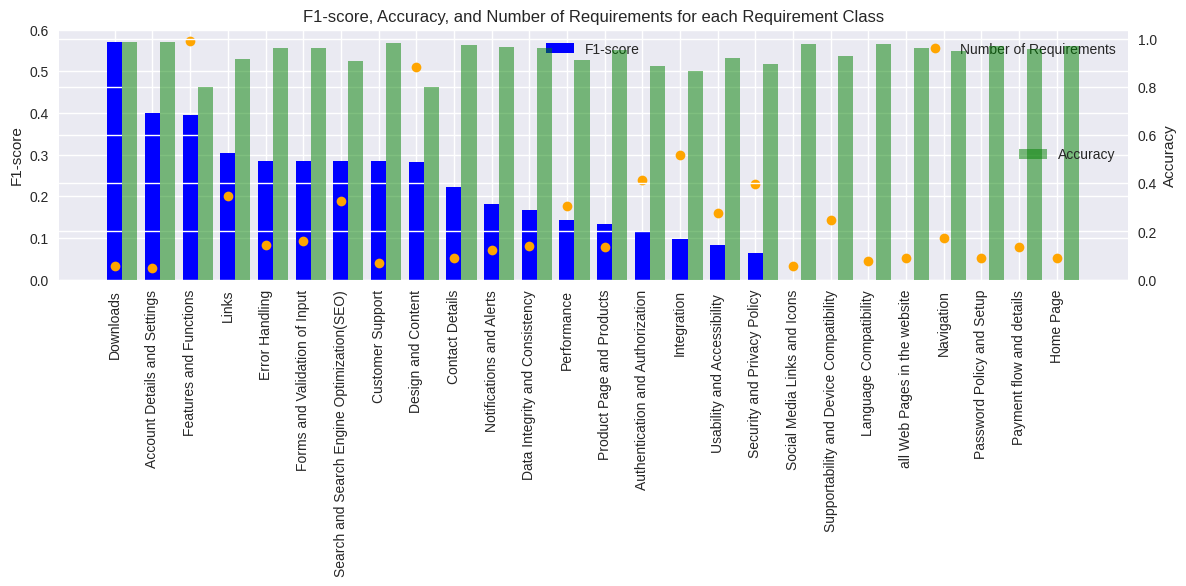

In [103]:
plot_scores_f1_accuracy(requirement_classes, nb_f1_score, nb_scores, class_requirements)

##Logistic regression

In [104]:
# Initialize a dictionary to store linear regression classifiers
lr_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a linear regression classifier for the current task
    lr_classifier = LogisticRegression()
  
    # Fit the classifier to the training data for the current task
    lr_classifier.fit(hv_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    lr_classifiers[cl] = lr_classifier

# Create a dictionary to store predicted tags for each classification task
lr_pred = {}

# Create a dictionary to store accuracy scores for each classification task
lr_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
lr_precision = {}
lr_recall = {}
lr_f1_score = {}
lr_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    
    # Transform the test data using TfidfVectorizer
    hv_test = hv_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    lr_pred[cl] = lr_classifiers[cl].predict(hv_test)
    
    #lr_pred[cl] = lr_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    lr_scores[cl] = metrics.accuracy_score(y_class_test[cl], lr_pred[cl])
    #print("Accuracy score for", cl, ":", lr_scores[cl])

    # Calculate the confusion matrix for the current task
    lr_cms[cl] = metrics.confusion_matrix(y_class_test[cl], lr_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", lr_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    lr_precision[cl] = metrics.precision_score(y_class_test[cl], lr_pred[cl])
    lr_recall[cl] = metrics.recall_score(y_class_test[cl], lr_pred[cl])
    lr_f1_score[cl] = metrics.f1_score(y_class_test[cl], lr_pred[cl])
    
    #print("Precision for", cl, ":", lr_precision[cl])
    #print("Recall for", cl, ":", lr_recall[cl])
    #print("F1-score for", cl, ":", lr_f1_score[cl], '\n')


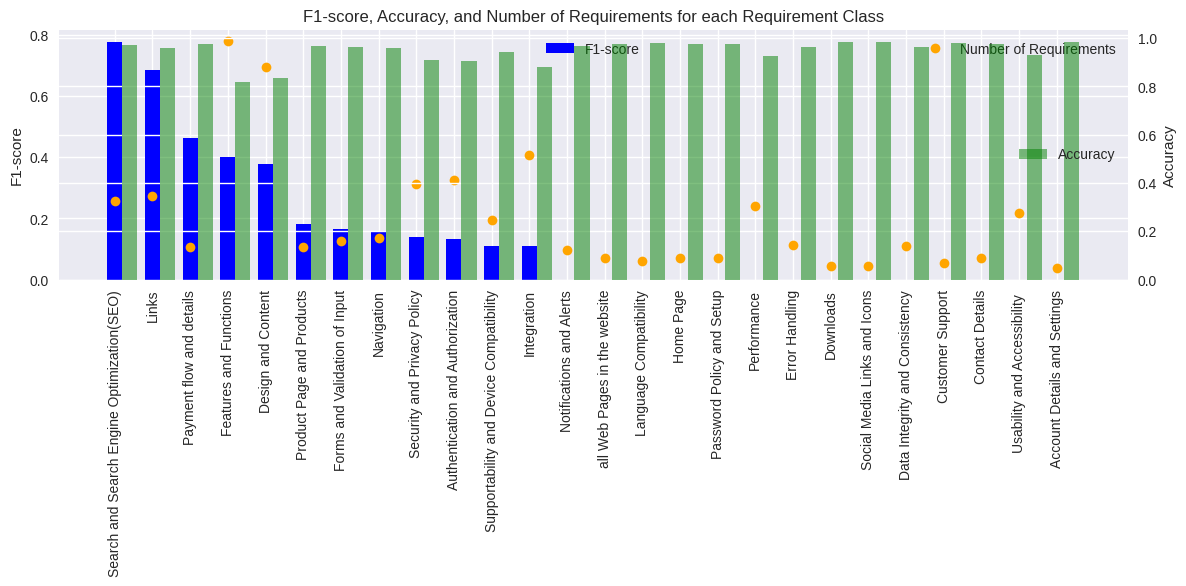

In [105]:
plot_scores_f1_accuracy(requirement_classes, lr_f1_score, lr_scores, class_requirements)

##Random forest

In [106]:
# Initialize a dictionary to store Random Forest classifiers
rf_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Random Forest classifier for the current task
    rf_classifier = RandomForestClassifier()
  
    # Fit the classifier to the training data for the current task
    rf_classifier.fit(hv_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    rf_classifiers[cl] = rf_classifier

# Create a dictionary to store predicted tags for each classification task
rf_pred = {}

# Create a dictionary to store accuracy scores for each classification task
rf_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
rf_precision = {}
rf_recall = {}
rf_f1_score = {}
rf_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    hv_test = hv_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    rf_pred[cl] = rf_classifiers[cl].predict(hv_test)
    
    # Predict the tags for the test data of the current task
    #rf_pred[cl] = rf_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    rf_scores[cl] = metrics.accuracy_score(y_class_test[cl], rf_pred[cl])
    #print("Accuracy score for", cl, ":", rf_scores[cl])

    # Calculate the confusion matrix for the current task
    rf_cms[cl] = metrics.confusion_matrix(y_class_test[cl], rf_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", rf_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    rf_precision[cl] = metrics.precision_score(y_class_test[cl], rf_pred[cl])
    rf_recall[cl] = metrics.recall_score(y_class_test[cl], rf_pred[cl])
    rf_f1_score[cl] = metrics.f1_score(y_class_test[cl], rf_pred[cl])

    # Print precision, recall, and F1-score for the current task
    #print("Precision for", cl, ":", rf_precision[cl])
    #print("Recall for", cl, ":", rf_recall[cl])
    #print("F1-score for", cl, ":", rf_f1_score[cl], '\n')


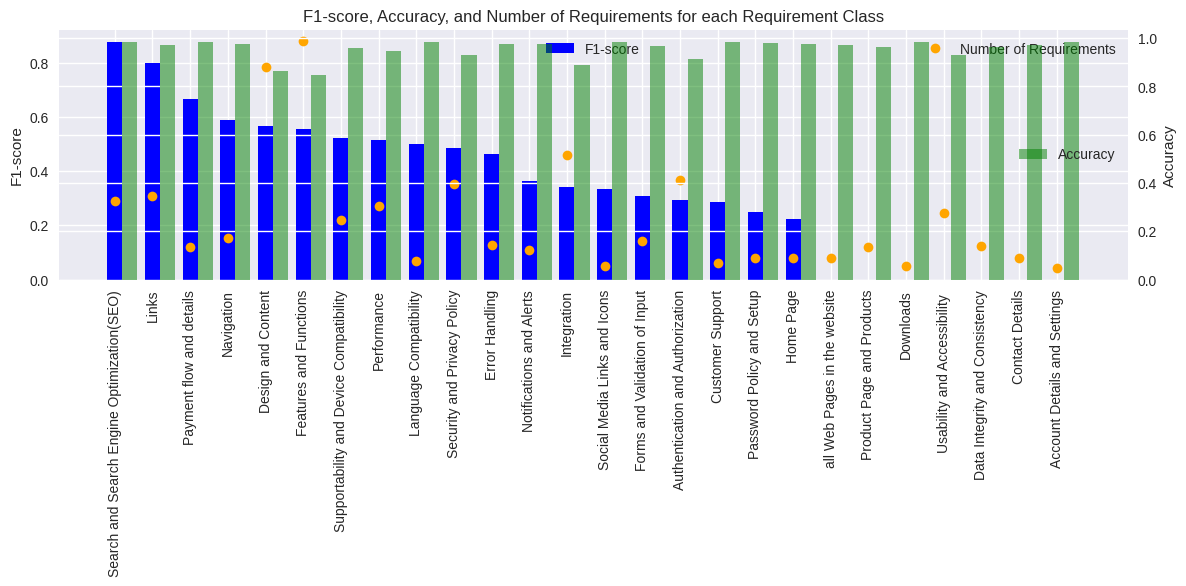

In [107]:
plot_scores_f1_accuracy(requirement_classes, rf_f1_score, rf_scores, class_requirements)

##KNN

In [108]:
# Initialize a dictionary to store KNN classifiers
knn_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a KNN classifier for the current task
    knn_classifier = KNeighborsClassifier()
  
    # Fit the classifier to the training data for the current task
    knn_classifier.fit(hv_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    knn_classifiers[cl] = knn_classifier

# Create a dictionary to store predicted tags for each classification task
knn_pred = {}

# Create a dictionary to store accuracy scores for each classification task
knn_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
knn_precision = {}
knn_recall = {}
knn_f1_score = {}
knn_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    hv_test = hv_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    knn_pred[cl] = knn_classifiers[cl].predict(hv_test)
    
    # Predict the tags for the test data of the current task
    #knn_pred[cl] = knn_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    knn_scores[cl] = metrics.accuracy_score(y_class_test[cl], knn_pred[cl])
    #print("Accuracy score for", cl, ":", knn_scores[cl])

    # Calculate the confusion matrix for the current task
    knn_cms[cl] = metrics.confusion_matrix(y_class_test[cl], knn_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", knn_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    knn_precision[cl] = metrics.precision_score(y_class_test[cl], knn_pred[cl])
    knn_recall[cl] = metrics.recall_score(y_class_test[cl], knn_pred[cl])
    knn_f1_score[cl] = metrics.f1_score(y_class_test[cl], knn_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", f1_score[cl], '\n')


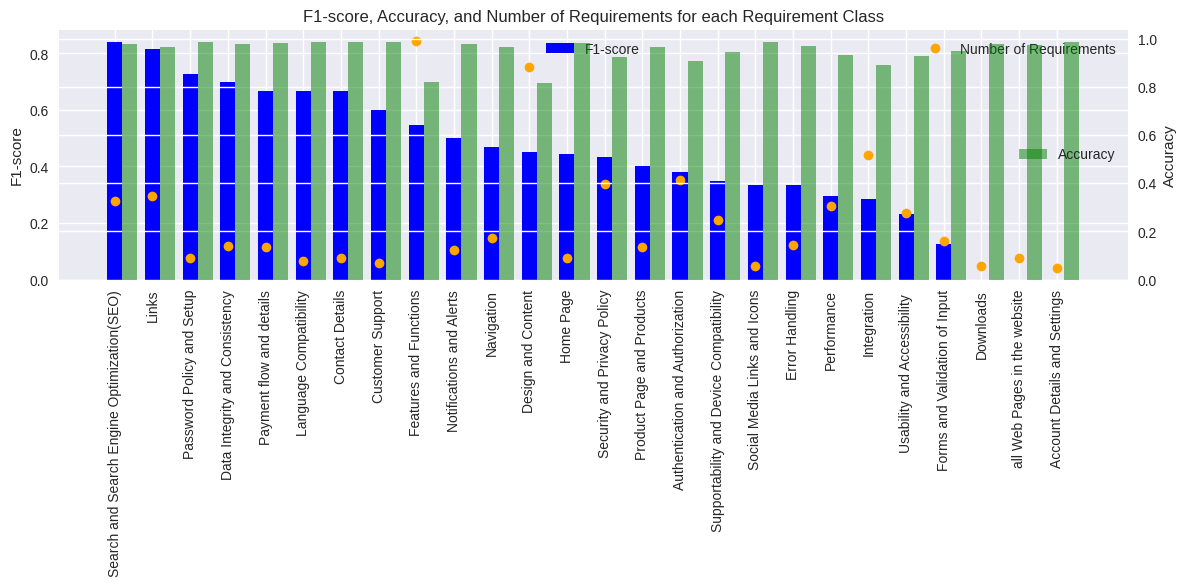

In [109]:
plot_scores_f1_accuracy(requirement_classes, knn_f1_score, knn_scores, class_requirements)

##Decision tree

In [110]:

# Initialize a dictionary to store Decision Tree classifiers
dtc_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Decision Tree classifier for the current task
    dtc_classifier = DecisionTreeClassifier()
  
    # Fit the classifier to the training data for the current task
    dtc_classifier.fit(hv_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    dtc_classifiers[cl] = dtc_classifier

# Create a dictionary to store predicted tags for each classification task
dtc_pred = {}

# Create a dictionary to store accuracy scores for each classification task
dtc_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
dtc_precision = {}
dtc_recall = {}
dtc_f1_score = {}
dtc_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    hv_test = hv_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    dtc_pred[cl] = dtc_classifiers[cl].predict(hv_test)

    # Predict the tags for the test data of the current task
    #dtc_pred[cl] = dtc_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    dtc_scores[cl] = metrics.accuracy_score(y_class_test[cl], dtc_pred[cl])
    print("Accuracy score for", cl, ":", dtc_scores[cl])

    # Calculate the confusion matrix for the current task
    dtc_cms[cl] = metrics.confusion_matrix(y_class_test[cl], dtc_pred[cl], labels=[1, 0])
    print("Confusion matrix for", cl, ":\n", dtc_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    dtc_precision[cl] = metrics.precision_score(y_class_test[cl], dtc_pred[cl])
    dtc_recall[cl] = metrics.recall_score(y_class_test[cl], dtc_pred[cl])
    dtc_f1_score[cl] = metrics.f1_score(y_class_test[cl], dtc_pred[cl])

Accuracy score for Account Details and Settings : 0.9820143884892086
Confusion matrix for Account Details and Settings :
 [[  1   3]
 [  2 272]]
Accuracy score for Authentication and Authorization : 0.920863309352518
Confusion matrix for Authentication and Authorization :
 [[ 13  15]
 [  7 243]]
Accuracy score for Contact Details : 0.9820143884892086
Confusion matrix for Contact Details :
 [[  5   2]
 [  3 268]]
Accuracy score for Customer Support : 0.9712230215827338
Confusion matrix for Customer Support :
 [[  2   4]
 [  4 268]]
Accuracy score for Data Integrity and Consistency : 0.9640287769784173
Confusion matrix for Data Integrity and Consistency :
 [[  4   6]
 [  4 264]]
Accuracy score for Design and Content : 0.8129496402877698
Confusion matrix for Design and Content :
 [[ 30  28]
 [ 24 196]]
Accuracy score for Downloads : 0.9820143884892086
Confusion matrix for Downloads :
 [[  3   2]
 [  3 270]]
Accuracy score for Error Handling : 0.9784172661870504
Confusion matrix for Error 

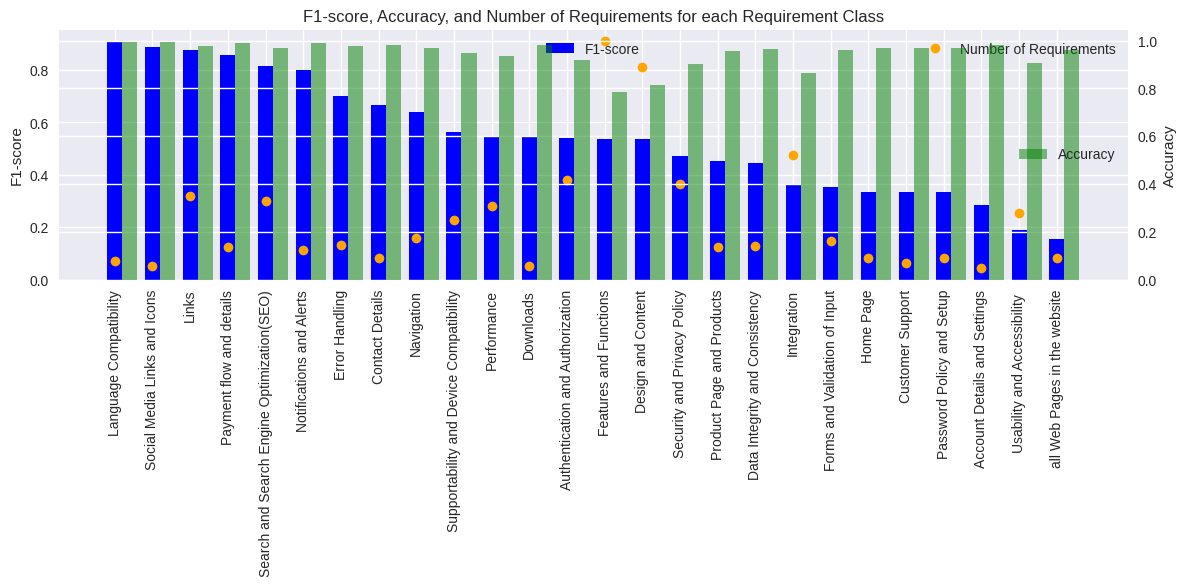

In [111]:
plot_scores_f1_accuracy(requirement_classes, dtc_f1_score, dtc_scores, class_requirements)

##SVC

In [112]:
# Import the necessary modules
from sklearn.svm import SVC

# Initialize a dictionary to store SVC classifiers
svc_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate an SVC classifier for the current task
    svc_classifier = SVC()
  
    # Fit the classifier to the training data for the current task
    svc_classifier.fit(hv_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    svc_classifiers[cl] = svc_classifier

# Create a dictionary to store predicted tags for each classification task
svc_pred = {}

# Create a dictionary to store accuracy scores for each classification task
svc_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
svc_precision = {}
svc_recall = {}
svc_f1_score = {}
svc_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    hv_test = hv_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    svc_pred[cl] = svc_classifiers[cl].predict(hv_test)
    # Predict the tags for the test data of the current task
    #svc_pred[cl] = svc_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    svc_scores[cl] = metrics.accuracy_score(y_class_test[cl], svc_pred[cl])
    #print("Accuracy score for", cl, ":", svc_scores[cl])

    # Calculate the confusion matrix for the current task
    svc_cms[cl] = metrics.confusion_matrix(y_class_test[cl], svc_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", svc_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    svc_precision[cl] = metrics.precision_score(y_class_test[cl], svc_pred[cl])
    svc_recall[cl] = metrics.recall_score(y_class_test[cl], svc_pred[cl])
    svc_f1_score[cl] = metrics.f1_score(y_class_test[cl], svc_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", f1_score[cl], '\n')


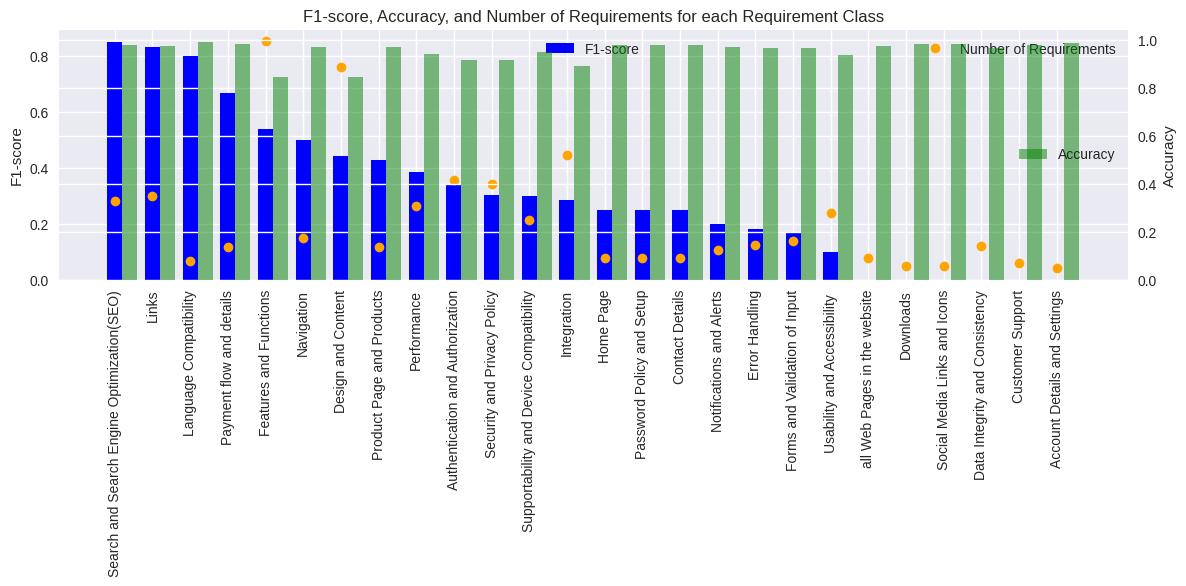

In [113]:
plot_scores_f1_accuracy(requirement_classes, svc_f1_score, svc_scores, class_requirements)

##Methods comparison for TfidfVectorizer

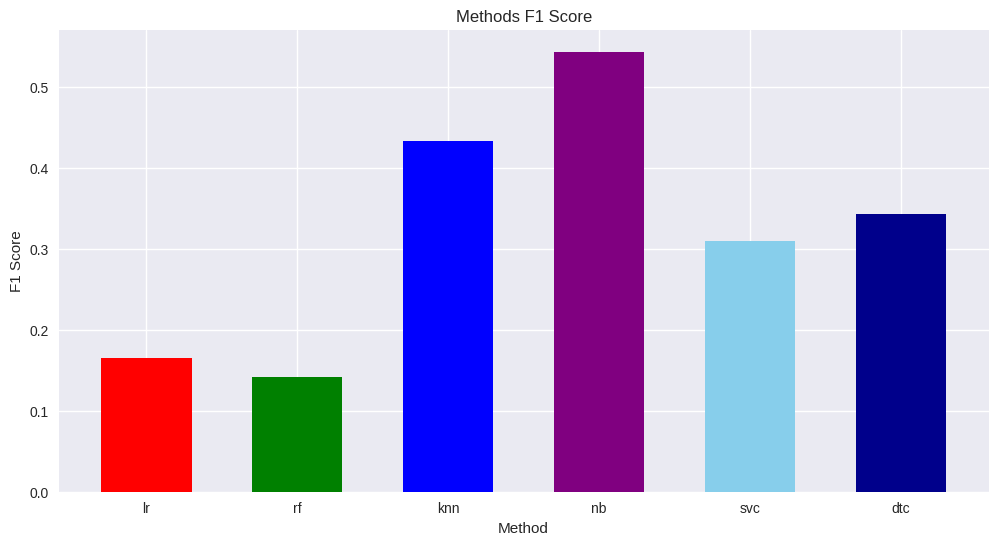

In [114]:
#@title f1_scores
# Create a list to store the F1-scores
f1_metrics = []

# Append the F1-scores for each classifier to the list
f1_metrics.append(list(nb_f1_score.values()))
f1_metrics.append(list(lr_f1_score.values()))
f1_metrics.append(list(knn_f1_score.values()))
f1_metrics.append(list(dtc_f1_score.values()))
f1_metrics.append(list(svc_f1_score.values()))
f1_metrics.append(list(rf_f1_score.values()))

plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers, [np.mean(scores) for scores in f1_metrics], width=0.6, color=['red', 'green', 'blue', 'purple', 'skyblue', 'darkblue'])
plt.title('Methods F1 Score')
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.show()


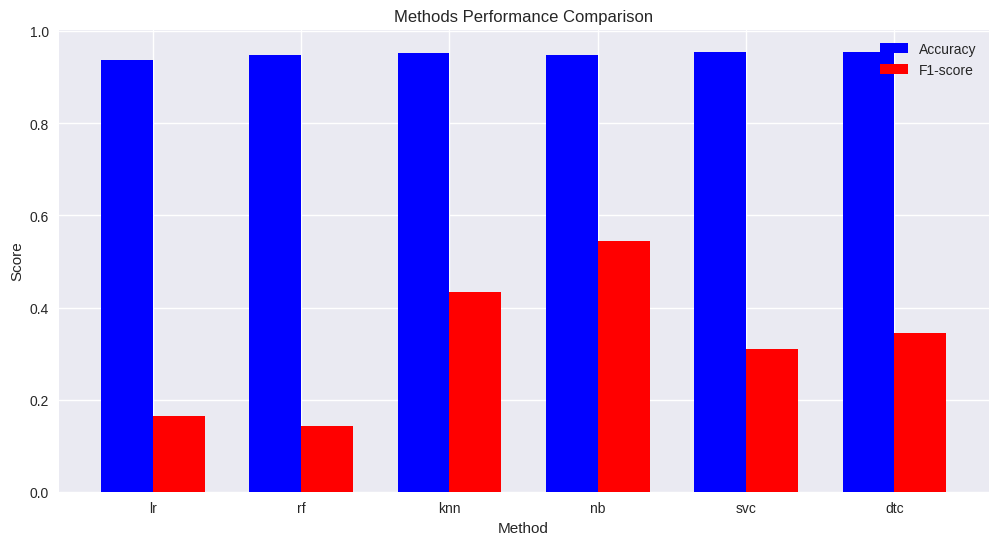

In [115]:
#@title Methods Performance Comparison for CountVectorizer
# Create a list to store the F1-scores
scores_ = []

# Append the F1-scores for each classifier to the list
scores_.append(list(nb_scores.values()))
scores_.append(list(lr_scores.values()))
scores_.append(list(knn_scores.values()))
scores_.append(list(dtc_scores.values()))
scores_.append(list(svc_scores.values()))
scores_.append(list(rf_scores.values()))

# Create a list to store the F1-scores
f1_metrics = []

# Append the F1-scores for each classifier to the list
f1_metrics.append(list(nb_f1_score.values()))
f1_metrics.append(list(lr_f1_score.values()))
f1_metrics.append(list(knn_f1_score.values()))
f1_metrics.append(list(dtc_f1_score.values()))
f1_metrics.append(list(svc_f1_score.values()))
f1_metrics.append(list(rf_f1_score.values()))

bar_width = 0.35
offset = np.arange(len(classifiers))

plt.style.use('seaborn')

plt.figure(figsize=(12, 6))

# Plot the accuracy scores
plt.bar(offset - bar_width/2, [np.mean(scores) for scores in scores_], width=bar_width, label='Accuracy', color='blue')

# Plot the F1-scores
plt.bar(offset + bar_width/2, [np.mean(scores) for scores in f1_metrics], width=bar_width, label='F1-score', color='red')

plt.title('Methods Performance Comparison')
plt.xlabel('Method')
plt.ylabel('Score')
plt.xticks(offset, classifiers)
plt.legend()
plt.show()


# Gensim TFIDF

###initialization

In [116]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [118]:
term_max_document_frequency = 2**10 #@param

In [119]:
# Initialize dictionaries to store TF-IDF vectorizers and transformed data
genTFIDF_vectorizers = dict()
genTFIDF_train = dict()
genTFIDF_test = dict()

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a TfidfVectorizer for the current task
    genTFIDF_vectorizers[cl] = TfidfVectorizer(stop_words="english", max_df=term_max_document_frequency)

    # Transform the training data using the TfidfVectorizer
    genTFIDF_train[cl] = genTFIDF_vectorizers[cl].fit_transform(X_class_train[cl])

    # Transform the test data using the TfidfVectorizer
    genTFIDF_test[cl] = genTFIDF_vectorizers[cl].transform(X_class_test[cl])


##Naive bias

In [120]:


# Initialize a dictionary to store naive bias classifiers
nb_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Bernoulli Naive Bayes classifier for the current task
    nb_classifier = BernoulliNB() # AS MultinomialNB cannot work with negative values

    # Fit the classifier to the training data for the current task
    nb_classifier.fit(genTFIDF_train[cl], y_class_train[cl])

    # Store the classifier in the dictionary
    nb_classifiers[cl] = nb_classifier

# Create a dictionary to store predicted tags for each classification task
nb_pred = {}

# Create a dictionary to store accuracy scores for each classification task
nb_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
nb_precision = {}
nb_recall = {}
nb_f1_score = {}
nb_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    genTFIDF_test = genTFIDF_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    nb_pred[cl] = nb_classifiers[cl].predict(genTFIDF_test)

    # Calculate the accuracy score for the current task
    nb_scores[cl] = metrics.accuracy_score(y_class_test[cl], nb_pred[cl])
    #print("Accuracy score for", cl, ":", nb_scores[cl])

    # Calculate the confusion matrix for the current task
    nb_cms[cl] = metrics.confusion_matrix(y_class_test[cl], nb_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", nb_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    nb_precision[cl] = metrics.precision_score(y_class_test[cl], nb_pred[cl])
    nb_recall[cl] = metrics.recall_score(y_class_test[cl], nb_pred[cl])
    nb_f1_score[cl] = metrics.f1_score(y_class_test[cl], nb_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", nb_f1_score[cl], '\n')


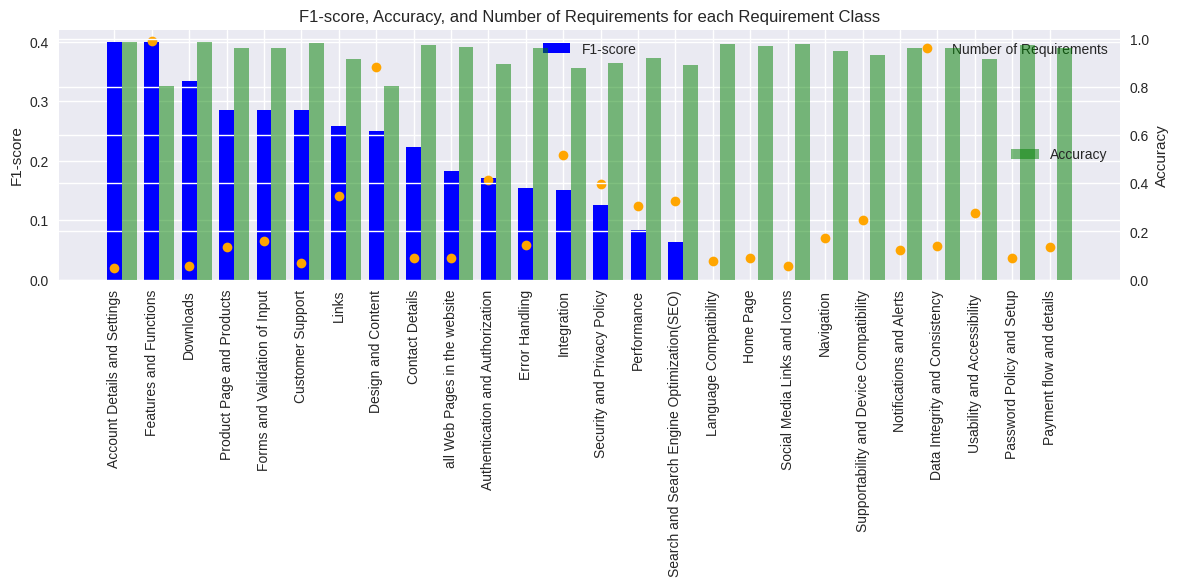

In [121]:
plot_scores_f1_accuracy(requirement_classes, nb_f1_score, nb_scores, class_requirements)

##Logistic regression

In [122]:
# Initialize a dictionary to store linear regression classifiers
lr_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a linear regression classifier for the current task
    lr_classifier = LogisticRegression()
  
    # Fit the classifier to the training data for the current task
    lr_classifier.fit(genTFIDF_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    lr_classifiers[cl] = lr_classifier

# Create a dictionary to store predicted tags for each classification task
lr_pred = {}

# Create a dictionary to store accuracy scores for each classification task
lr_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
lr_precision = {}
lr_recall = {}
lr_f1_score = {}
lr_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    
    # Transform the test data using TfidfVectorizer
    genTFIDF_test = genTFIDF_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    lr_pred[cl] = lr_classifiers[cl].predict(genTFIDF_test)
    
    #lr_pred[cl] = lr_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    lr_scores[cl] = metrics.accuracy_score(y_class_test[cl], lr_pred[cl])
    #print("Accuracy score for", cl, ":", lr_scores[cl])

    # Calculate the confusion matrix for the current task
    lr_cms[cl] = metrics.confusion_matrix(y_class_test[cl], lr_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", lr_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    lr_precision[cl] = metrics.precision_score(y_class_test[cl], lr_pred[cl])
    lr_recall[cl] = metrics.recall_score(y_class_test[cl], lr_pred[cl])
    lr_f1_score[cl] = metrics.f1_score(y_class_test[cl], lr_pred[cl])
    
    #print("Precision for", cl, ":", lr_precision[cl])
    #print("Recall for", cl, ":", lr_recall[cl])
    #print("F1-score for", cl, ":", lr_f1_score[cl], '\n')


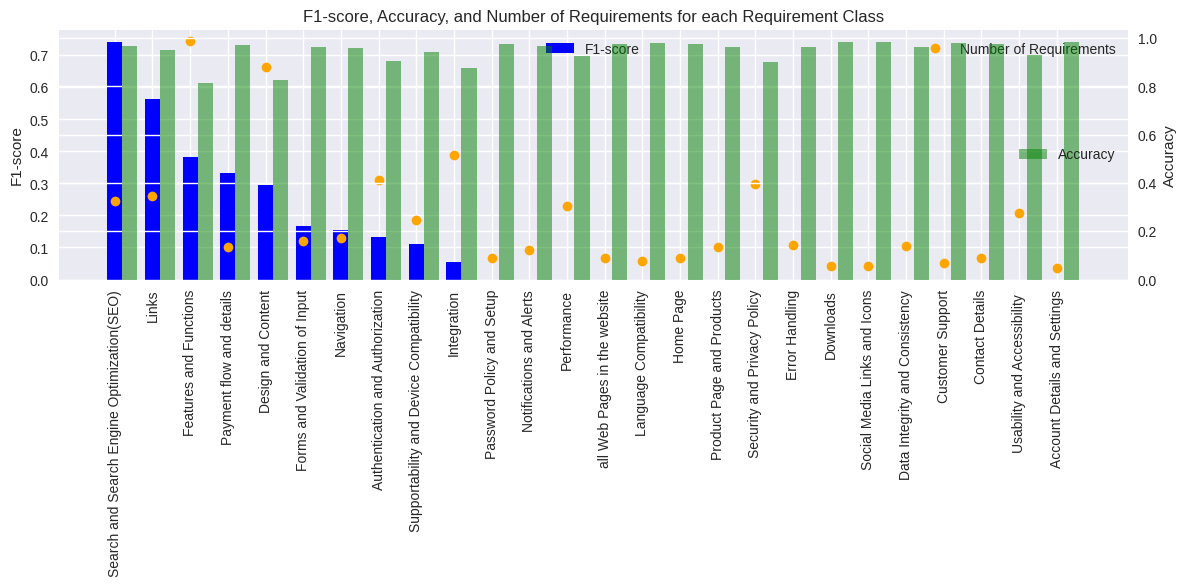

In [123]:
plot_scores_f1_accuracy(requirement_classes, lr_f1_score, lr_scores, class_requirements)

##Random forest

In [124]:
# Initialize a dictionary to store Random Forest classifiers
rf_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Random Forest classifier for the current task
    rf_classifier = RandomForestClassifier()
  
    # Fit the classifier to the training data for the current task
    rf_classifier.fit(genTFIDF_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    rf_classifiers[cl] = rf_classifier

# Create a dictionary to store predicted tags for each classification task
rf_pred = {}

# Create a dictionary to store accuracy scores for each classification task
rf_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
rf_precision = {}
rf_recall = {}
rf_f1_score = {}
rf_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    genTFIDF_test = genTFIDF_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    rf_pred[cl] = rf_classifiers[cl].predict(genTFIDF_test)
    
    # Predict the tags for the test data of the current task
    #rf_pred[cl] = rf_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    rf_scores[cl] = metrics.accuracy_score(y_class_test[cl], rf_pred[cl])
    #print("Accuracy score for", cl, ":", rf_scores[cl])

    # Calculate the confusion matrix for the current task
    rf_cms[cl] = metrics.confusion_matrix(y_class_test[cl], rf_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", rf_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    rf_precision[cl] = metrics.precision_score(y_class_test[cl], rf_pred[cl])
    rf_recall[cl] = metrics.recall_score(y_class_test[cl], rf_pred[cl])
    rf_f1_score[cl] = metrics.f1_score(y_class_test[cl], rf_pred[cl])

    # Print precision, recall, and F1-score for the current task
    #print("Precision for", cl, ":", rf_precision[cl])
    #print("Recall for", cl, ":", rf_recall[cl])
    #print("F1-score for", cl, ":", rf_f1_score[cl], '\n')


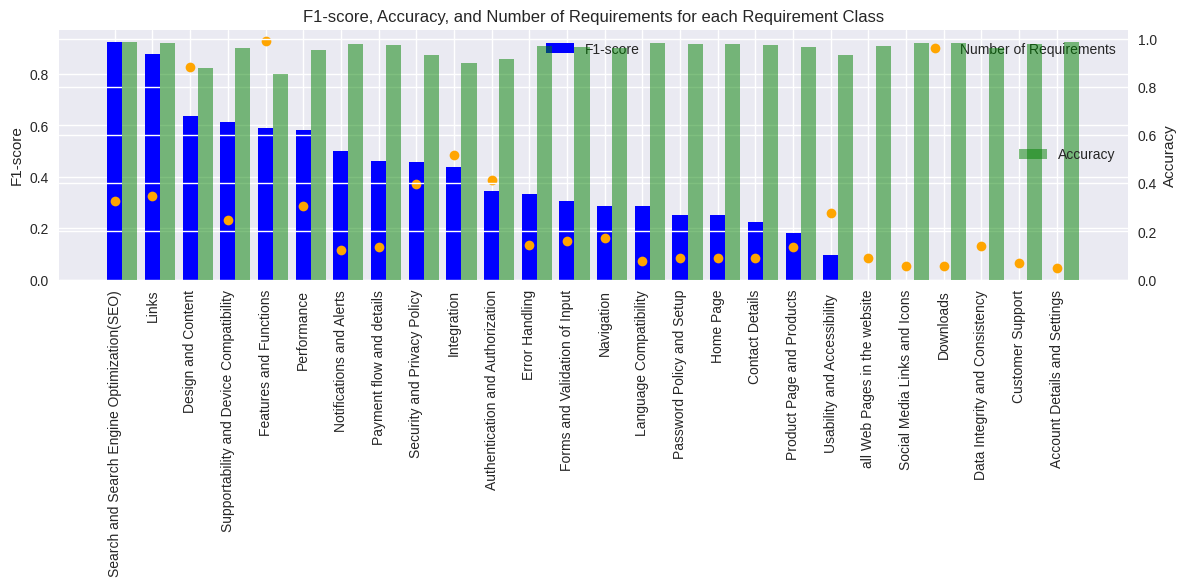

In [125]:
plot_scores_f1_accuracy(requirement_classes, rf_f1_score, rf_scores, class_requirements)

##KNN

In [126]:
# Initialize a dictionary to store KNN classifiers
knn_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a KNN classifier for the current task
    knn_classifier = KNeighborsClassifier()
  
    # Fit the classifier to the training data for the current task
    knn_classifier.fit(genTFIDF_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    knn_classifiers[cl] = knn_classifier

# Create a dictionary to store predicted tags for each classification task
knn_pred = {}

# Create a dictionary to store accuracy scores for each classification task
knn_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
knn_precision = {}
knn_recall = {}
knn_f1_score = {}
knn_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    genTFIDF_test = genTFIDF_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    knn_pred[cl] = knn_classifiers[cl].predict(genTFIDF_test)
    
    # Predict the tags for the test data of the current task
    #knn_pred[cl] = knn_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    knn_scores[cl] = metrics.accuracy_score(y_class_test[cl], knn_pred[cl])
    #print("Accuracy score for", cl, ":", knn_scores[cl])

    # Calculate the confusion matrix for the current task
    knn_cms[cl] = metrics.confusion_matrix(y_class_test[cl], knn_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", knn_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    knn_precision[cl] = metrics.precision_score(y_class_test[cl], knn_pred[cl])
    knn_recall[cl] = metrics.recall_score(y_class_test[cl], knn_pred[cl])
    knn_f1_score[cl] = metrics.f1_score(y_class_test[cl], knn_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", f1_score[cl], '\n')


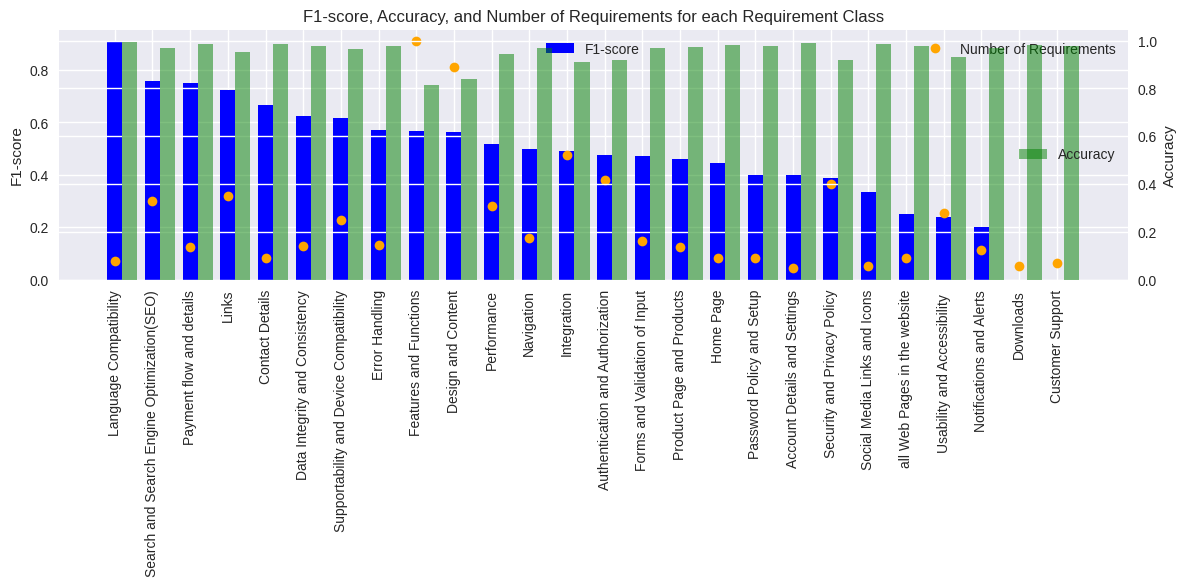

In [127]:
plot_scores_f1_accuracy(requirement_classes, knn_f1_score, knn_scores, class_requirements)

##Decision tree

In [128]:

# Initialize a dictionary to store Decision Tree classifiers
dtc_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Decision Tree classifier for the current task
    dtc_classifier = DecisionTreeClassifier()
  
    # Fit the classifier to the training data for the current task
    dtc_classifier.fit(genTFIDF_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    dtc_classifiers[cl] = dtc_classifier

# Create a dictionary to store predicted tags for each classification task
dtc_pred = {}

# Create a dictionary to store accuracy scores for each classification task
dtc_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
dtc_precision = {}
dtc_recall = {}
dtc_f1_score = {}
dtc_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    genTFIDF_test = genTFIDF_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    dtc_pred[cl] = dtc_classifiers[cl].predict(genTFIDF_test)

    # Predict the tags for the test data of the current task
    #dtc_pred[cl] = dtc_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    dtc_scores[cl] = metrics.accuracy_score(y_class_test[cl], dtc_pred[cl])
    print("Accuracy score for", cl, ":", dtc_scores[cl])

    # Calculate the confusion matrix for the current task
    dtc_cms[cl] = metrics.confusion_matrix(y_class_test[cl], dtc_pred[cl], labels=[1, 0])
    print("Confusion matrix for", cl, ":\n", dtc_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    dtc_precision[cl] = metrics.precision_score(y_class_test[cl], dtc_pred[cl])
    dtc_recall[cl] = metrics.recall_score(y_class_test[cl], dtc_pred[cl])
    dtc_f1_score[cl] = metrics.f1_score(y_class_test[cl], dtc_pred[cl])

Accuracy score for Account Details and Settings : 0.9784172661870504
Confusion matrix for Account Details and Settings :
 [[  1   3]
 [  3 271]]
Accuracy score for Authentication and Authorization : 0.9100719424460432
Confusion matrix for Authentication and Authorization :
 [[ 11  17]
 [  8 242]]
Accuracy score for Contact Details : 0.9820143884892086
Confusion matrix for Contact Details :
 [[  6   1]
 [  4 267]]
Accuracy score for Customer Support : 0.9784172661870504
Confusion matrix for Customer Support :
 [[  2   4]
 [  2 270]]
Accuracy score for Data Integrity and Consistency : 0.9388489208633094
Confusion matrix for Data Integrity and Consistency :
 [[  1   9]
 [  8 260]]
Accuracy score for Design and Content : 0.7949640287769785
Confusion matrix for Design and Content :
 [[ 28  30]
 [ 27 193]]
Accuracy score for Downloads : 0.9892086330935251
Confusion matrix for Downloads :
 [[  4   1]
 [  2 271]]
Accuracy score for Error Handling : 0.9820143884892086
Confusion matrix for Error

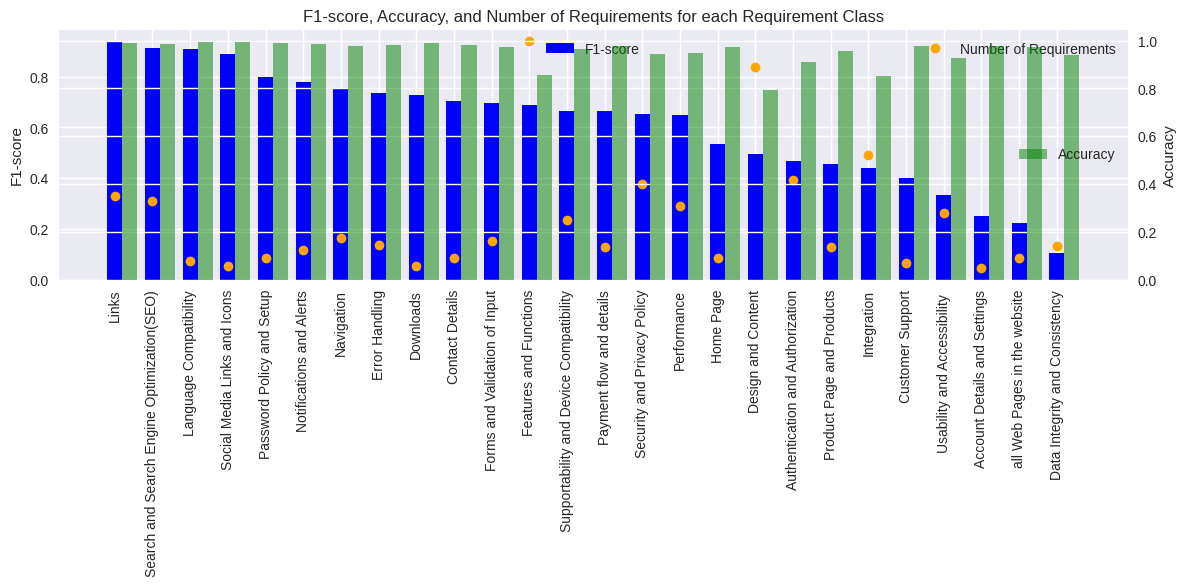

In [129]:
plot_scores_f1_accuracy(requirement_classes, dtc_f1_score, dtc_scores, class_requirements)

##Support vectors classification

In [130]:
# Import the necessary modules
from sklearn.svm import SVC

# Initialize a dictionary to store SVC classifiers
svc_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate an SVC classifier for the current task
    svc_classifier = SVC()
  
    # Fit the classifier to the training data for the current task
    svc_classifier.fit(genTFIDF_train[cl], y_class_train[cl])
  
    # Store the classifier in the dictionary
    svc_classifiers[cl] = svc_classifier

# Create a dictionary to store predicted tags for each classification task
svc_pred = {}

# Create a dictionary to store accuracy scores for each classification task
svc_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
svc_precision = {}
svc_recall = {}
svc_f1_score = {}
svc_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    genTFIDF_test = genTFIDF_vectorizers[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    svc_pred[cl] = svc_classifiers[cl].predict(genTFIDF_test)
    # Predict the tags for the test data of the current task
    #svc_pred[cl] = svc_classifiers[cl].predict(tfidf_test[cl])
  
    # Calculate the accuracy score for the current task
    svc_scores[cl] = metrics.accuracy_score(y_class_test[cl], svc_pred[cl])
    #print("Accuracy score for", cl, ":", svc_scores[cl])

    # Calculate the confusion matrix for the current task
    svc_cms[cl] = metrics.confusion_matrix(y_class_test[cl], svc_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", svc_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    svc_precision[cl] = metrics.precision_score(y_class_test[cl], svc_pred[cl])
    svc_recall[cl] = metrics.recall_score(y_class_test[cl], svc_pred[cl])
    svc_f1_score[cl] = metrics.f1_score(y_class_test[cl], svc_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", f1_score[cl], '\n')


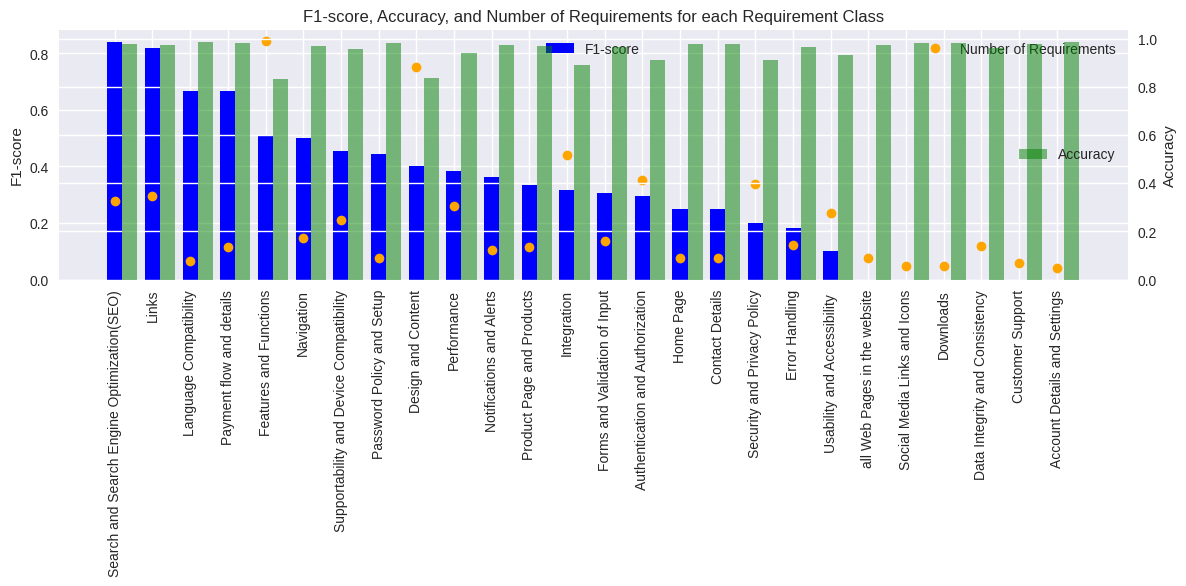

In [131]:
plot_scores_f1_accuracy(requirement_classes, svc_f1_score, svc_scores, class_requirements)

##Methods comparison for TfidfVectorizer

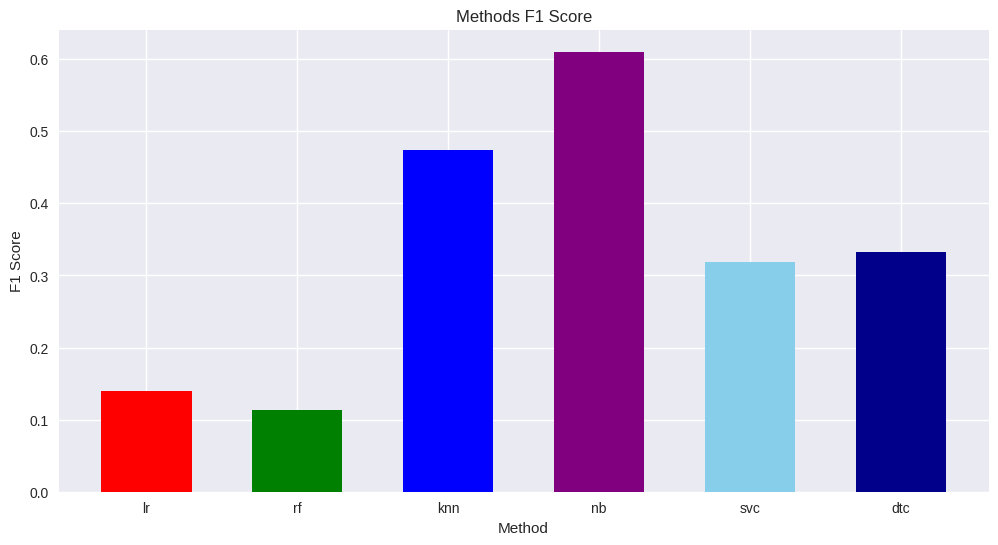

In [132]:
#@title f1_scores
# Create a list to store the F1-scores
f1_metrics = []

# Append the F1-scores for each classifier to the list
f1_metrics.append(list(nb_f1_score.values()))
f1_metrics.append(list(lr_f1_score.values()))
f1_metrics.append(list(knn_f1_score.values()))
f1_metrics.append(list(dtc_f1_score.values()))
f1_metrics.append(list(svc_f1_score.values()))
f1_metrics.append(list(rf_f1_score.values()))

plt.style.use('seaborn')

plt.figure(figsize=(12,6))
plt.bar(classifiers, [np.mean(scores) for scores in f1_metrics], width=0.6, color=['red', 'green', 'blue', 'purple', 'skyblue', 'darkblue'])
plt.title('Methods F1 Score')
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.show()


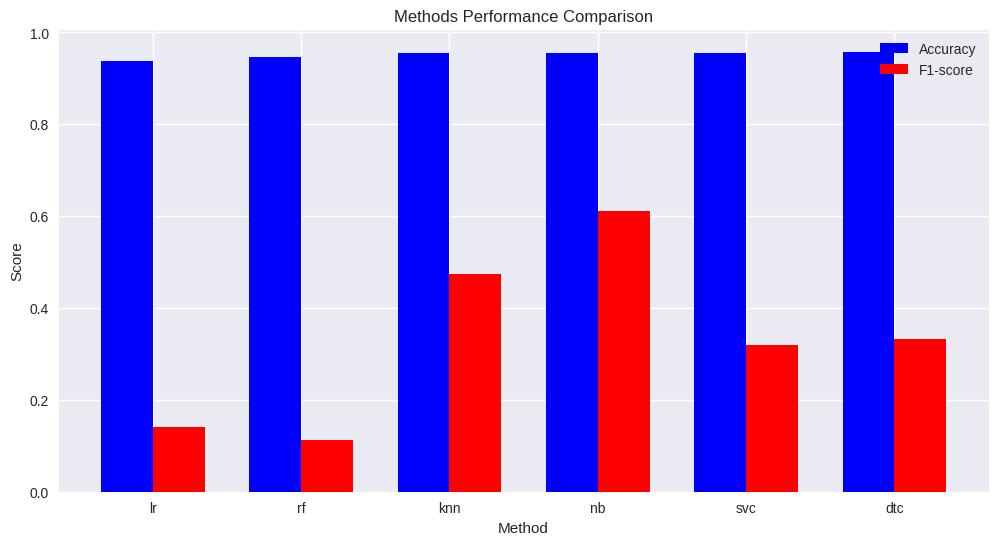

In [133]:
#@title Methods Performance Comparison for CountVectorizer
# Create a list to store the F1-scores
scores_ = []

# Append the F1-scores for each classifier to the list
scores_.append(list(nb_scores.values()))
scores_.append(list(lr_scores.values()))
scores_.append(list(knn_scores.values()))
scores_.append(list(dtc_scores.values()))
scores_.append(list(svc_scores.values()))
scores_.append(list(rf_scores.values()))

# Create a list to store the F1-scores
f1_metrics = []

# Append the F1-scores for each classifier to the list
f1_metrics.append(list(nb_f1_score.values()))
f1_metrics.append(list(lr_f1_score.values()))
f1_metrics.append(list(knn_f1_score.values()))
f1_metrics.append(list(dtc_f1_score.values()))
f1_metrics.append(list(svc_f1_score.values()))
f1_metrics.append(list(rf_f1_score.values()))

bar_width = 0.35
offset = np.arange(len(classifiers))

plt.style.use('seaborn')

plt.figure(figsize=(12, 6))

# Plot the accuracy scores
plt.bar(offset - bar_width/2, [np.mean(scores) for scores in scores_], width=bar_width, label='Accuracy', color='blue')

# Plot the F1-scores
plt.bar(offset + bar_width/2, [np.mean(scores) for scores in f1_metrics], width=bar_width, label='F1-score', color='red')

plt.title('Methods Performance Comparison')
plt.xlabel('Method')
plt.ylabel('Score')
plt.xticks(offset, classifiers)
plt.legend()
plt.show()


#BERT

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'  # Replace with the specific BERT model you want to use
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Initialize dictionaries to store BERT embeddings
bert_embeddings_train = {}
bert_embeddings_test = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Tokenize the training data
    tokenized_train = [tokenizer.encode(text, add_special_tokens=True) for text in X_class_train[cl]]

    # Tokenize the test data
    tokenized_test = [tokenizer.encode(text, add_special_tokens=True) for text in X_class_test[cl]]

    # Pad the tokenized sequences
    max_length = max(max(len(seq) for seq in tokenized_train), max(len(seq) for seq in tokenized_test))
    padded_train = [seq + [0] * (max_length - len(seq)) for seq in tokenized_train]
    padded_test = [seq + [0] * (max_length - len(seq)) for seq in tokenized_test]

    # Convert the padded sequences to tensors
    input_ids_train = torch.tensor(padded_train)
    input_ids_test = torch.tensor(padded_test)

    # Generate BERT embeddings for the training data
    with torch.no_grad():
        train_outputs = model(input_ids_train)
        bert_embeddings_train[cl] = train_outputs[0].numpy()

    # Generate BERT embeddings for the test data
    with torch.no_grad():
        test_outputs = model(input_ids_test)
        bert_embeddings_test[cl] = test_outputs[0].numpy()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#@title BERT model download and training on dataset

# Initialize a dictionary to store naive bias classifiers
nb_classifiers = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Instantiate a Bernoulli Naive Bayes classifier for the current task
    nb_classifier = BernoulliNB() # AS MultinomialNB cannot work with negative values

    # Fit the classifier to the training data for the current task
    nb_classifier.fit(bert_embeddings_train[cl], y_class_train[cl])

    # Store the classifier in the dictionary
    nb_classifiers[cl] = nb_classifier

# Create a dictionary to store predicted tags for each classification task
nb_pred = {}

# Create a dictionary to store accuracy scores for each classification task
nb_scores = {}

# Create dictionaries to store precision, recall, and F1-score for each classification task
nb_precision = {}
nb_recall = {}
nb_f1_score = {}
nb_cms = {}

# Iterate over each classification task
for cl in requirement_classes:
    # Transform the test data using TfidfVectorizer
    bert_embeddings_test = tokenizer[cl].transform(X_class_test[cl])

    # Predict the tags for the test data of the current task
    nb_pred[cl] = nb_classifiers[cl].predict(bert_embeddings_test)

    # Calculate the accuracy score for the current task
    nb_scores[cl] = metrics.accuracy_score(y_class_test[cl], nb_pred[cl])
    #print("Accuracy score for", cl, ":", nb_scores[cl])

    # Calculate the confusion matrix for the current task
    nb_cms[cl] = metrics.confusion_matrix(y_class_test[cl], nb_pred[cl], labels=[1, 0])
    #print("Confusion matrix for", cl, ":\n", nb_cms[cl])

    # Calculate precision, recall, and F1-score for the current task
    nb_precision[cl] = metrics.precision_score(y_class_test[cl], nb_pred[cl])
    nb_recall[cl] = metrics.recall_score(y_class_test[cl], nb_pred[cl])
    nb_f1_score[cl] = metrics.f1_score(y_class_test[cl], nb_pred[cl])

    #print("Precision for", cl, ":", precision[cl])
    #print("Recall for", cl, ":", recall[cl])
    #print("F1-score for", cl, ":", nb_f1_score[cl], '\n')
